# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'C:/Users/ryoiwata/Documents/GitHub/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
# import seaborn as sns



In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
# from spectral_connectivity import Multitaper, Connectivity
# import spectral_connectivity

In [11]:
import utilities.helper
import trodes.read_exported

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

In [14]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

In [15]:
# BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_PLOT = {'theta': (4, 12)}
BAND_TO_FREQ_COLOR = {'theta': "#FFAF00", 'beta': "blue", 'gamma': "green"}

## Inputs & Data

In [16]:
EPHYS_SAMPLE_RATE = 20000

In [17]:
# GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3", "5.2", "5.3"]
# GOOD_SUBJECTS = ["3.1", "4.2", "4.3"]
# GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3"]
GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3", "5.2", "5.3"]
# GOOD_SUBJECTS = ["3.1", "4.2", "4.3", "5.3"]

# GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3"]


Explanation of each input and where it comes from.

In [18]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIXES = ["rce_pilot_3_alone_comp", "rce_pilot_3_long_comp"]
OUTPUT_PREFIX = "rce_pilot_3_combined"

In [19]:
# TRIAL_LABELS_DF = pd.read_excel("/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_comp_ext/results/2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx")
TRIALS_AND_SPECTRAL_DF = pd.concat([pd.read_pickle("./proc/{}_10_per_trial_spectral_bans_sleap.pkl".format(prefix)) for prefix in OUTPUT_PREFIXES])

In [20]:
FULL_LFP_TRACES_PKL = "{}_12_per_cluster_spectral_bans_sleap.pkl".format(OUTPUT_PREFIX)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [21]:
def combine_dicts(dicts):
    """
    Combine lists from multiple dictionaries that share the same key.

    This function takes a list of dictionaries where each dictionary's values are lists of numbers.
    It merges these lists for each corresponding key across all dictionaries, producing a single
    dictionary where each key has a combined list of all numbers from the input dictionaries.

    Parameters:
        dicts (list of dict): A list of dictionaries with values as lists of numbers.

    Returns:
        dict: A dictionary with keys from the input dictionaries and values as merged lists 
        of numbers from all corresponding input dictionary values.
    """
    combined = defaultdict(list)
    for dictionary in dicts:
        for key, value in dictionary.items():
            combined[key].extend(value)
    
    return dict(combined)


# Example usage
list_of_dicts = [
    {'a': [1, 2], 'b': [3, 4]},
    {'a': [5], 'b': [6, 7]},
    {'a': [8, 9], 'c': [10]}
]

combined_dict = combine_dicts(list_of_dicts)
print(combined_dict)

{'a': [1, 2, 5, 8, 9], 'b': [3, 4, 6, 7], 'c': [10]}


In [22]:
def find_consecutive_ranges(numbers, min_length=1):
    """
    Finds the start and end indices for consecutive ranges of each number in a list where the range meets a minimum length.

    This function iterates through a list of integers and identifies ranges where the same integer appears consecutively
    and the length of this sequence meets or exceeds the specified minimum length.

    Parameters:
        numbers (list): A list of integers to analyze for consecutive ranges.
        min_length (int): The minimum length of a range for it to be included in the results.

    Returns:
        dict: A dictionary with integers as keys and a list of tuples (start, end) as values,
              where each tuple represents the start and end indices (inclusive) of consecutive ranges
              for that integer. Only ranges that meet or exceed the minimum length are included.
    """
    ranges = {}
    n = len(numbers)
    if n == 0:
        return ranges
    
    start = 0
    current = numbers[0]

    for i in range(1, n):
        if numbers[i] != current:
            if (i - start) >= min_length:
                if current not in ranges:
                    ranges[current] = []
                ranges[current].append((start, i - 1))
            current = numbers[i]
            start = i

    # Handle the last range
    if (n - start) >= min_length:
        if current not in ranges:
            ranges[current] = []
        ranges[current].append((start, n - 1))

    return ranges

# Example usage:
numbers = [1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1]
print(find_consecutive_ranges(numbers, min_length=3))

{2: [(2, 4)], 3: [(5, 8)]}


In [23]:
def update_tuples_in_dict(original_dict, reference_list):
    """
    Updates the values in the tuples within a dictionary by replacing indices with corresponding values from a reference list.
    
    This function iterates through each key-value pair in the original dictionary. Each value is expected to be a list of tuples,
    where each tuple contains indices. These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_dict (dict): Dictionary whose values are lists of tuples. Each tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_dict.
        
    Returns:
        dict: A dictionary with the same keys as original_dict but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new dictionary to store the updated key-value pairs
    new_dict = {}
    for key, list_of_tuples in original_dict.items():
        # Process each tuple in the list associated with the current key
        updated_tuples = [
            tuple(reference_list[idx] for idx in tup) for tup in list_of_tuples
        ]
        new_dict[key] = updated_tuples
    
    return new_dict

# Example usage:
original_dict = {
    'a': [(0, 1), (2, 3)],
    'b': [(1, 3), (0, 2)]
}
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_dict = update_tuples_in_dict(original_dict, reference_list)
print(updated_dict)

{'a': [('alpha', 'beta'), ('gamma', 'delta')], 'b': [('beta', 'delta'), ('alpha', 'gamma')]}


In [24]:
# def find_indices_within_ranges(ranges_dict, values):
#     """
#     Creates a dictionary mapping keys to sorted indices of values that fall within specified ranges.
    
#     Parameters:
#         ranges_dict (dict): A dictionary with keys and values as lists of tuples representing ranges.
#         values (list): A list of values to check against the ranges.
        
#     Returns:
#         dict: A dictionary where each key maps to a sorted list of indices for values within the ranges.
#     """
#     result_dict = {}
#     for key, ranges in ranges_dict.items():
#         matched_indices = []
#         for index, value in enumerate(values):
#             if any(start <= value <= end for start, end in ranges):
#                 matched_indices.append(index)
#         result_dict[key] = sorted(matched_indices)
#     return list(result_dict.items())

# # Example usage:
# ranges_dict = {
#     'range1': [(1, 5), (10, 15)],
#     'range2': [(0, 2), (4, 8)]
# }
# values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# result = find_indices_within_ranges(ranges_dict, values)
# print(result)


In [25]:
def update_tuples_in_list(original_list, reference_list):
    """
    Updates the values in the tuples within a list by replacing indices with corresponding values from a reference list.
    
    This function iterates through each tuple in the original list. Each tuple is expected to contain indices.
    These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_list (list): List of tuples. Each inner tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_list.
        
    Returns:
        list: A list with the same structure as original_list but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new list to store the updated tuples
    new_list = [
        tuple(reference_list[idx] for idx in tup) for tup in original_list
    ]
    
    return new_list

# Example usage:
original_list = [
    (0, 1), (2, 3),
    (1, 3), (0, 2)
]
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_list = update_tuples_in_list(original_list, reference_list)
print(updated_list)

[('alpha', 'beta'), ('gamma', 'delta'), ('beta', 'delta'), ('alpha', 'gamma')]


In [26]:
def find_indices_within_ranges(ranges_list, values):
    """
    Finds the indices of values that fall within specified ranges.
    
    Parameters:
        ranges_list (list): A list of tuples representing ranges.
        values (list): A list of values to check against the ranges.
        
    Returns:
        list: A list of sorted indices for values within the ranges.
    """
    matched_indices = []
    for index, value in enumerate(values):
        if any(start <= value <= end for start, end in ranges_list):
            matched_indices.append(index)
    
    return sorted(matched_indices)

# Example usage:
ranges_list = [(1, 5), (10, 15), (0, 2), (4, 8)]
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

result = find_indices_within_ranges(ranges_list, values)
print(result)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]


In [27]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [28]:
comp_id_to_color = {'competitive_1': "#281640",
'competitive_2': "#43246a",
'competitive_3': "#8e7ca6",
'no_comp_4': "#2f3600",
'no_comp_5': "#535f00",
'no_comp_6': "#768800",
'no_comp_7': "#9fac4d",
'no_comp_8': "#c8cf99",
'competitive': "#43246A",
'no_comp': "#768800",
'win': "#0045A6",
'win_competitive': "#003074",
'win_no_comp': "#4d7dc1",
'lose': "#792910",
'lose_competitive': "#551d0b",
'lose_no_comp': "#a16958",
'rewarded': "#FFAF00"
}

In [29]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [30]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




## Renaming the trial labels

In [31]:
TRIALS_AND_SPECTRAL_DF.head()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0              1272          1352            1372.0             1471   
1              1272          1352            1372.0             1471   
2              3268          3348            3368.0             3469   
3              3268          3348            3368.0             3469   
4              4466          4546            4566.0             4667   

  condition competition_closeness  get_reward_frame  out_reward_frame  \
0  rewarded                   NaN               NaN               NaN   
1  rewarded                   NaN               NaN               NaN   
2  rewarded                   NaN               NaN               NaN   
3  rewarded                   NaN               NaN               NaN   
4  rewarded                   NaN               NaN               NaN   

   experiment                                     video_name  ...  \
0  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   

                           baseline_mPFC_gamma_phase  \
0  [-2.6797059, -2.3968484, -2.1131911, -1.828970...   
1  [-1.0192864, -0.7884174, -0.5577601, -0.327317...   
2  [0.032740027, 0.27976346, 0.52697045, 0.774348...   
3  [1.9588519, 2.221262, 2.4844332, 2.7484064, 3....   
4  [2.3436375, 2.551059, 2.757349, 2.9625306, -3....   

                             baseline_mPFC_lfp_trace  \
0  [45.434998, 53.039997, 63.569996, 94.575, 114....   
1  [232.635, 241.79999, 253.49998, 259.935, 290.5...   
2  [128.50499, 109.979996, 77.415, 22.619999, -20...   
3  [56.55, -39.195, -152.09999, -172.185, -144.10...   
4  [60.644997, 38.805, 30.81, 48.554996, 77.805, ...   

                            baseline_mPFC_theta_band  \
0  [0.3023039, 0.3250822, 0.34729052, 0.3688477, ...   
1  [0.86803913, 0.8516945, 0.83444965, 0.8164087,...   
2  [0.31883484, 0.304557, 0.28981718, 0.27463654,...   
3  [0.019023584, 0.033879466, 0.04848842, 0.06283...   
4  [0.60134304, 0.6429786, 0.68366385, 0.7233099,...   

                           baseline_mPFC_theta_phase  \
0  [-0.788324, -0.7305608, -0.67332137, -0.616575...   
1  [0.042734537, 0.07712564, 0.1110838, 0.1445905...   
2  [0.82180655, 0.86382616, 0.90566295, 0.9473232...   
3  [-1.5093546, -1.4610933, -1.4133036, -1.365974...   
4  [-1.0260117, -0.98588574, -0.9458348, -0.90586...   

                            baseline_vHPC_gamma_band  \
0  [0.11822242, 0.026445314, -0.061667122, -0.141...   
1  [0.04515997, 0.09145398, 0.13580361, 0.1756941...   
2  [-0.1966364, -0.20901106, -0.2086731, -0.19691...   
3  [-0.034169298, -0.058782697, -0.0758774, -0.08...   
4  [-0.031517684, 0.033092283, 0.09645234, 0.1545...   

                           baseline_vHPC_gamma_phase  \
0  [1.2789538, 1.5046133, 1.7300067, 1.9551437, 2...   
1  [-1.3614203, -1.1462942, -0.92886734, -0.70931...   
2  [2.5922303, 2.8197713, 3.0456688, -3.0136209, ...   
3  [1.9731913, 2.3358655, 2.7034516, 3.0720255, -...   
4  [-1.6889625, -1.4474249, -1.2057016, -0.963856...   

                             baseline_vHPC_lfp_trace  \
0  [-4.875, -0.39, 26.519999, 62.399998, 69.615, ...   
1  [221.715, 238.09499, 259.935, 264.03, 253.305,...   
2  [-46.995, -35.489998, -35.684998, -43.484997, ...   
3  [0.78, 53.82, 101.59499, 119.729996, 94.77, 49...   
4  [223.665, 226.39499, 232.04999, 241.995, 243.1...   

                            baseline_vHPC_theta_band  \
0  [0.45442012, 0.4403637, 0.4263141, 0.4122978, ...   
1  [0.49248752, 0.49964046, 0.50668645, 0.5136666...   
2  [0.24851131, 0.20672616, 0.16414632, 0.1208212...   
3  [-0.0010840435, 0.03636438, 0.0744549, 0.11305...   
4  [1.0194497, 1.0016606, 0.98306626, 0.9636855, ...   

                    

In [32]:
comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

In [33]:
# cluster_to_competitiveness = {"0": "no_comp", "1": "competitive", "2": "competitive", "3": "no_comp", "4": "competitive", "5": "no_comp", "6": "no_comp", "7": "no_comp"}
# cluster_to_comp_id = {"0": "no_comp_8", "1": "competitive_3", "2": "competitive_1", "3": "no_comp_6", "4": "competitive_2", "5": "no_comp_7", "6": "no_comp_5", "7": "no_comp_4"}
# comp_id = {"no_comp_8", "competitive_3", "competitive_1", "no_comp_6", "competitive_2", "no_comp_7", "no_comp_5", "no_comp_4"}


Win base color
#0045A6 
Win competitive color
#003074
Win no comp color
#4d7dc1

Lose base color
#792910
Lose competitive color
#551d0b
Lose no comp color
#a16958

In [34]:
TRIALS_AND_SPECTRAL_DF["current_subject"] = TRIALS_AND_SPECTRAL_DF["current_subject"].apply(lambda x: str(x).strip().lower())

In [35]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["current_subject"].isin(GOOD_SUBJECTS)]

In [36]:
TRIALS_AND_SPECTRAL_DF["current_subject"].unique()

array(['3.1', '3.3', '4.2', '4.3', '3.4', '5.2', '5.3'], dtype=object)

In [37]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["condition"] != "tie"].reset_index(drop=True)

In [38]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["condition"] != "temp"].reset_index(drop=True)

In [39]:
TRIALS_AND_SPECTRAL_DF["condition"].unique()

array(['rewarded', 3.1, 3.3, 4.3, 3.4, 4.4, 5.3, 4.2, 5.4, 5.2],
      dtype=object)

In [40]:
TRIALS_AND_SPECTRAL_DF["condition"] = TRIALS_AND_SPECTRAL_DF["condition"].apply(lambda x: str(x).strip().lower())

In [41]:
TRIALS_AND_SPECTRAL_DF["trial_label"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: "win" if x["current_subject"] == x["condition"]  else ("lose" if x["agent"] == x["condition"] else x["condition"]), axis=1)
                                                                        

In [42]:
TRIALS_AND_SPECTRAL_DF["trial_label"].unique()

array(['rewarded', 'win', 'lose'], dtype=object)

In [43]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"] = TRIALS_AND_SPECTRAL_DF["competition_closeness"].map(comp_closeness_dict).fillna("rewarded")

In [44]:
TRIALS_AND_SPECTRAL_DF["trial_label"].unique()

array(['rewarded', 'win', 'lose'], dtype=object)

In [45]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"].unique()

array(['rewarded', 'no_comp', 'competitive'], dtype=object)

## Making separate rows for each cluster

In [46]:
TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"]

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
1138    {'competitive': [(50311, 50319), (50462, 50491...
1139    {'no_comp': [(51709, 51822), (52220, 52250), (...
1140    {'no_comp': [(51709, 51822), (52220, 52250), (...
1141    {'competitive': [(53904, 53948), (53980, 54023...
1142    {'competitive': [(53904, 53948), (53980, 54023...
Name: competitiveness_frame_ranges_dict, Length: 1143, dtype: object

In [47]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].iloc[0]

{np.str_('competitive'): [(np.int64(34040), np.int64(34045)),
  (np.int64(34241), np.int64(34257)),
  (np.int64(34264), np.int64(34298)),
  (np.int64(34433), np.int64(34536)),
  (np.int64(34545), np.int64(34639))],
 np.str_('no_comp'): [(np.int64(34046), np.int64(34240)),
  (np.int64(34258), np.int64(34263)),
  (np.int64(34299), np.int64(34432)),
  (np.int64(34537), np.int64(34544))]}

In [48]:
TRIALS_AND_SPECTRAL_DF["tone_start_frame"].head()

0    1272
1    1272
2    3268
3    3268
4    4466
Name: tone_start_frame, dtype: int64

In [49]:
TRIALS_AND_SPECTRAL_DF["tone_stop_frame"]

0        1471
1        1471
2        3469
3        3469
4        4667
        ...  
1138    50711
1139    52108
1140    52108
1141    54304
1142    54304
Name: tone_stop_frame, Length: 1143, dtype: int64

- Making each dictionary into a list so that we can explode it

In [50]:
dict_col = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "dict" in col and "competitiveness" in col]


In [51]:
dict_col

['competitiveness_index_ranges_dict', 'competitiveness_frame_ranges_dict']

In [52]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_index_ranges_dict"].iloc[0]

{np.str_('competitive'): [(0, 5),
  (201, 217),
  (224, 258),
  (393, 496),
  (505, 599)],
 np.str_('no_comp'): [(6, 200), (218, 223), (259, 392), (497, 504)]}

In [53]:
for col in dict_col:
    TRIALS_AND_SPECTRAL_DF[col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: list(x[col].items()) if isinstance(x[col], dict) else [("rewarded", [(x["tone_start_frame"], x["tone_stop_frame"])])], axis=1)

In [54]:
TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].head()

0    [(rewarded, [(1272, 1471)])]
1    [(rewarded, [(1272, 1471)])]
2    [(rewarded, [(3268, 3469)])]
3    [(rewarded, [(3268, 3469)])]
4    [(rewarded, [(4466, 4667)])]
Name: competitiveness_frame_ranges_dict, dtype: object

In [55]:
TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].head()

42    [(competitive, [(np.int64(34040), np.int64(340...
43    [(competitive, [(np.int64(34040), np.int64(340...
44    [(no_comp, [(np.int64(35038), np.int64(35090))...
45    [(no_comp, [(np.int64(35038), np.int64(35090))...
46    [(no_comp, [(np.int64(36137), np.int64(36386))...
Name: competitiveness_frame_ranges_dict, dtype: object

- Exploding each row so that competitive and non-competitive clusters are on different rows

In [56]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.explode(column=dict_col)

In [57]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].head()

0    (rewarded, [(1272, 1471)])
1    (rewarded, [(1272, 1471)])
2    (rewarded, [(3268, 3469)])
3    (rewarded, [(3268, 3469)])
4    (rewarded, [(4466, 4667)])
Name: competitiveness_frame_ranges_dict, dtype: object

In [58]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges_dict"].head()

42    (competitive, [(34040, 34045), (34241, 34257),...
42    (no_comp, [(34046, 34240), (34258, 34263), (34...
43    (competitive, [(34040, 34045), (34241, 34257),...
43    (no_comp, [(34046, 34240), (34258, 34263), (34...
44    (no_comp, [(35038, 35090), (35167, 35172), (35...
Name: competitiveness_frame_ranges_dict, dtype: object

- Making a new column based on the key which is the competitiveness of the group

In [59]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].apply(lambda x: str(x[0]))

In [60]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].iloc[0]

'rewarded'

In [61]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].head()

0    rewarded
1    rewarded
2    rewarded
3    rewarded
4    rewarded
Name: competitiveness_label, dtype: object

In [62]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_label"].head()

42    competitive
42        no_comp
43    competitive
43        no_comp
44        no_comp
Name: competitiveness_label, dtype: object

- Filtering rows that don't have matching frame and trial competitiveness

In [63]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"].unique()

array(['rewarded', 'competitive', 'no_comp'], dtype=object)

In [64]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competition_closeness"].unique()

array(['rewarded', 'no_comp', 'competitive'], dtype=object)

In [65]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.shape

(1752, 410)

In [66]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competition_closeness"] == cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_label"]].reset_index(drop=True)

In [67]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.shape

(1143, 410)

- Combining the competitiveness and the trial outcome labels

In [68]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: "_".join([x["trial_label"], x["competitiveness_label"]]) if  x["trial_label"] != x["competitiveness_label"] else x["trial_label"], axis=1)

In [69]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique()

array(['rewarded', 'win_no_comp', 'lose_no_comp', 'win_competitive',
       'lose_competitive'], dtype=object)

- Making a new column that is the range of frames

In [70]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges_dict"].apply(lambda x: x[1])

In [71]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].head()

0    [(1272, 1471)]
1    [(1272, 1471)]
2    [(3268, 3469)]
3    [(3268, 3469)]
4    [(4466, 4667)]
Name: competitiveness_frame_ranges, dtype: object

In [72]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_frame_ranges"].head()

42    [(34046, 34240), (34258, 34263), (34299, 34432...
43    [(34046, 34240), (34258, 34263), (34299, 34432...
44    [(35091, 35166), (35173, 35200), (35249, 35334...
45    [(35091, 35166), (35173, 35200), (35249, 35334...
46    [(36137, 36386), (36438, 36503), (36509, 36516...
Name: competitiveness_frame_ranges, dtype: object

- Filtering for ranges that are only during the trial

In [73]:
def adjust_frame_range(frame_range, event_range):
    """
    Adjusts the frame range based on the event range.

    Parameters:
        frame_range (tuple): The tuple representing the start and end of the frame range.
        event_range (tuple): The tuple representing the start and end of the event range.

    Returns:
        tuple or None: Adjusted frame range or None if there's no overlap.
    """
    # Unpack the ranges
    frame_start, frame_end = frame_range
    event_start, event_end = event_range

    # Check for overlap
    if frame_end < event_start or frame_start > event_end:
        return None  # No overlap

    # Adjust the start and end of the frame range
    adjusted_start = max(frame_start, event_start)
    adjusted_end = min(frame_end, event_end)

    return (adjusted_start, adjusted_end)

# Example Usage:
frame_range = (10, 20)
event_range = (15, 25)
result = adjust_frame_range(frame_range, event_range)
print(result)  # Output will be (15, 20)


(15, 20)


In [74]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["tone_start_frame"]

0        1272
1        1272
2        3268
3        3268
4        4466
        ...  
1138    50511
1139    51909
1140    51909
1141    54104
1142    54104
Name: tone_start_frame, Length: 1143, dtype: int64

In [75]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["tone_stop_frame"]

0        1471
1        1471
2        3469
3        3469
4        4667
        ...  
1138    50711
1139    52108
1140    52108
1141    54304
1142    54304
Name: tone_stop_frame, Length: 1143, dtype: int64

In [76]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: [adjust_frame_range((start, stop), (x["tone_start_frame"], x["tone_stop_frame"])) for start, stop in x["competitiveness_frame_ranges"] if adjust_frame_range((start, stop), (x["tone_start_frame"], x["tone_stop_frame"]))], axis=1)

- Filtering for rows that have at least one consecutive second

In [77]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: len(x) >= 1)]

- Filtering for ranges that are 1 second consecutive

In [78]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: [(start, stop) for start, stop in x if stop - start >= 20])

- Calculating the total number of frames for each trial

In [79]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: sum([stop - start for start, stop in x]))

In [80]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"]

0       199
1       199
2       201
3       201
4       201
       ... 
1138     69
1139    199
1140    199
1141    151
1142    151
Name: frame_ranges_sum_frames, Length: 1136, dtype: int64

- Filtering for rows where at least half the frames are there

In [81]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["frame_ranges_sum_frames"] >= 100]

In [82]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"]

0                         [(1272, 1471)]
1                         [(1272, 1471)]
2                         [(3268, 3469)]
3                         [(3268, 3469)]
4                         [(4466, 4667)]
                      ...               
1136    [(49514, 49589), (49676, 49713)]
1139                    [(51909, 52108)]
1140                    [(51909, 52108)]
1141    [(54120, 54212), (54245, 54304)]
1142    [(54120, 54212), (54245, 54304)]
Name: competitiveness_frame_ranges, Length: 1010, dtype: object

- Filtering for rows that have at least one consecutive second

In [83]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"].apply(lambda x: len(x) >= 1)]

In [84]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_frame_ranges"]

0                         [(1272, 1471)]
1                         [(1272, 1471)]
2                         [(3268, 3469)]
3                         [(3268, 3469)]
4                         [(4466, 4667)]
                      ...               
1136    [(49514, 49589), (49676, 49713)]
1139                    [(51909, 52108)]
1140                    [(51909, 52108)]
1141    [(54120, 54212), (54245, 54304)]
1142    [(54120, 54212), (54245, 54304)]
Name: competitiveness_frame_ranges, Length: 1010, dtype: object

In [85]:
for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns:
    print(col)

tone_start_frame
reward_start
reward_dispensed
tone_stop_frame
condition
competition_closeness
get_reward_frame
out_reward_frame
experiment
video_name
tone_start_timestamp
tone_stop_timestamp
cohort
session_dir
tone_frames
box_1_port_entry_frames
box_2_port_entry_frames
notes
session_path
recording
current_subject
subject
all_subjects
first_timestamp
last_timestamp
video_timestamps
tone_timestamps
box_1_port_entry_timestamps
box_2_port_entry_timestamps
power_calculation_frequencies
coherence_calculation_frequencies
granger_calculation_frequencies
tone_start_frame_remove
agent_tail_base
agent_to_reward_port_angle
subject_tail_base
subject_to_reward_port_angle
to_reward_port_angle_diff
to_reward_port_angle_sum
within_trial_index
agent
10s_after_tone_frame
10s_before_tone_frame
all_subjects_remove
body_parts
box_bottom_left
box_bottom_right
box_number
box_top_left
box_top_right
color
comp_id
competition_closeness_remove
condition 
experiment_remove
first_timestamp_remove
get_reward_frame_

## Adding the velocity

In [86]:
alone_trials_df = pd.read_pickle("../2024_06_26_sleap_clustering/proc/alone_trials_sleap.pkl")

In [87]:
alone_trials_df.columns

Index(['unnamed: 0', 'session_dir', 'tone_start_frame', 'reward_start',
       'reward_dispensed', 'tone_stop_frame', 'condition',
       'competition_closeness', 'get_reward_frame', 'out_reward_frame',
       'notes', 'experiment', 'box_1_port_entry_frames',
       'box_2_port_entry_frames', 'video_name', 'all_subjects',
       'first_timestamp', 'last_timestamp', 'tone_start_timestamp',
       'tone_stop_timestamp', 'box_1_port_entry_timestamps',
       'box_2_port_entry_timestamps', '10s_before_tone_frame',
       '10s_after_tone_frame', 'tone_start_to_stop_frame', 'start_frame',
       'stop_frame', 'tracked_subject', 'in_video_subjects', 'box_number',
       'sleap_name', 'current_subject', 'body_parts', 'box_top_right',
       'box_bottom_right', 'box_top_left', 'reward_port', 'box_bottom_left',
       'agent', 'subject_locations', 'agent_locations', 'frame_index',
       'subject_thorax', 'subject_nose', 'subject_tail_base', 'agent_thorax',
       'agent_nose', 'agent_tail_base'

In [88]:
alone_trials_df["subject_thorax_velocity"].apply(lambda x: x.shape)

0      (599,)
1      (601,)
2      (601,)
3      (599,)
4      (599,)
        ...  
289    (601,)
290    (599,)
291    (599,)
292    (600,)
293    (601,)
Name: subject_thorax_velocity, Length: 294, dtype: object

In [89]:
alone_trials_df["trial_subject_thorax_velocity"] = alone_trials_df["subject_thorax_velocity"].apply(lambda x: x[199:399])

In [90]:
alone_trials_df["trial_frame_index"] = alone_trials_df["frame_index"].apply(lambda x: x[199:399])

In [91]:
alone_trial_to_velocity = {(row['session_dir'], row['current_subject'], row['tone_start_timestamp']): row['trial_subject_thorax_velocity'] for index, row in alone_trials_df.iterrows()}

In [92]:
alone_trial_to_frame_index = {(row['session_dir'], row['current_subject'], row['tone_start_timestamp']): row['trial_frame_index'] for index, row in alone_trials_df.iterrows()}

In [93]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_subject_thorax_velocity"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda row: alone_trial_to_velocity[(row['session_dir'], row['current_subject'], row['tone_start_timestamp'])] if (row['session_dir'], row['current_subject'], row['tone_start_timestamp']) in alone_trial_to_velocity else row["trial_subject_thorax_velocity"], axis=1)

In [94]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_frame_index"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda row: alone_trial_to_frame_index[(row['session_dir'], row['current_subject'], row['tone_start_timestamp'])] if (row['session_dir'], row['current_subject'], row['tone_start_timestamp']) in alone_trial_to_frame_index else row["trial_frame_index"], axis=1)

In [95]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_subject_thorax_velocity"].iloc[:5].apply(lambda x: x.shape)

0    (200,)
1    (200,)
2    (200,)
3    (200,)
4    (200,)
Name: trial_subject_thorax_velocity, dtype: object

In [96]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_frame_index"].iloc[:5].apply(lambda x: x.shape)

0    (200,)
1    (200,)
2    (200,)
3    (200,)
4    (200,)
Name: trial_frame_index, dtype: object

In [97]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_video_timestamps"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["video_timestamps"][x["trial_frame_index"]] if isinstance(pd.isna(x["trial_video_timestamps"]), bool) else x["trial_video_timestamps"], axis=1)

- Getting the timestamps for each frame

In [98]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_timestamp_ranges"] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_list(x["competitiveness_frame_ranges"], x["video_timestamps"]), axis=1)

In [99]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_label"] != "rewarded"]["competitiveness_timestamp_ranges"]

42                                 [(34336303, 34469346)]
43                                 [(34336303, 34469346)]
44      [(35288395, 35372933), (35395107, 35422824), (...
45      [(35288395, 35372933), (35395107, 35422824), (...
46           [(36377688, 36427580), (36478857, 36543993)]
                              ...                        
1136         [(49607199, 49682036), (49769346, 49806764)]
1139                               [(52007525, 52207090)]
1140                               [(52007525, 52207090)]
1141         [(54222145, 54314998), (54346873, 54406465)]
1142         [(54222145, 54314998), (54346873, 54406465)]
Name: competitiveness_timestamp_ranges, Length: 506, dtype: object

In [100]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["competitiveness_timestamp_ranges"]

0                               [(1276384, 1475949)]
1                               [(1276384, 1475949)]
2                               [(3276194, 3477145)]
3                               [(3276194, 3477145)]
4                               [(4476357, 4677308)]
                            ...                     
1136    [(49607199, 49682036), (49769346, 49806764)]
1139                          [(52007525, 52207090)]
1140                          [(52007525, 52207090)]
1141    [(54222145, 54314998), (54346873, 54406465)]
1142    [(54222145, 54314998), (54346873, 54406465)]
Name: competitiveness_timestamp_ranges, Length: 1010, dtype: object

- Getting all the spectral timestamps that are in the ranges

In [101]:
# timestamps_col = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "video" not in col and "trial" in col]
timestamps_col = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "trial" in col]

In [102]:
timestamps_col

['trial_video_timestamps',
 'trial_coherence_timestamps',
 'trial_granger_timestamps',
 'trial_power_timestamps',
 'trial_lfp_timestamps']

- Getting all the indexes that fit within each range

In [103]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_lfp_timestamps"]

0       [1275900, 1275920, 1275940, 1275960, 1275980, ...
1       [1275900, 1275920, 1275940, 1275960, 1275980, ...
2       [3275920, 3275940, 3275960, 3275980, 3276000, ...
3       [3275920, 3275940, 3275960, 3275980, 3276000, ...
4       [4475940, 4475960, 4475980, 4476000, 4476020, ...
                              ...                        
1136    [49606260, 49606280, 49606300, 49606320, 49606...
1139    [52006300, 52006320, 52006340, 52006360, 52006...
1140    [52006300, 52006320, 52006340, 52006360, 52006...
1141    [54206320, 54206340, 54206360, 54206380, 54206...
1142    [54206320, 54206340, 54206360, 54206380, 54206...
Name: trial_lfp_timestamps, Length: 1010, dtype: object

In [104]:
for col in timestamps_col:
    base_col = col.replace("trial_", "").replace("timestamps", "index")
    print(base_col)
    cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: find_indices_within_ranges(x["competitiveness_timestamp_ranges"], x[col]), axis=1)

video_index
coherence_index
granger_index
power_index
lfp_index


In [105]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_mPFC_theta_band"].iloc[0].shape

(10000,)

In [106]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)].iloc[0][:10]

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [107]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)].iloc[0][-10:]

[9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999]

In [108]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.head()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0              1272          1352            1372.0             1471   
1              1272          1352            1372.0             1471   
2              3268          3348            3368.0             3469   
3              3268          3348            3368.0             3469   
4              4466          4546            4566.0             4667   

  condition competition_closeness  get_reward_frame  out_reward_frame  \
0  rewarded              rewarded               NaN               NaN   
1  rewarded              rewarded               NaN               NaN   
2  rewarded              rewarded               NaN               NaN   
3  rewarded              rewarded               NaN               NaN   
4  rewarded              rewarded               NaN               NaN   

   experiment                                     video_name  ...  \
0  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4  alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   

   competitiveness_label  trial_and_competitiveness_label  \
0               rewarded                         rewarded   
1               rewarded                         rewarded   
2               rewarded                         rewarded   
3               rewarded                         rewarded   
4               rewarded                         rewarded   

  competitiveness_frame_ranges frame_ranges_sum_frames  \
0               [(1272, 1471)]                     199   
1               [(1272, 1471)]                     199   
2               [(3268, 3469)]                     201   
3               [(3268, 3469)]                     201   
4               [(4466, 4667)]                     201   

  competitiveness_timestamp_ranges  \
0             [(1276384, 1475949)]   
1             [(1276384, 1475949)]   
2             [(3276194, 3477145)]   
3             [(3276194, 3477145)]   
4             [(4476357, 4677308)]   

                        cluster_filtered_video_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                    cluster_filtered_coherence_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                      cluster_filtered_granger_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                        cluster_filtered_power_index  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                          cluster_filtered_lfp_index  
0  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...  
1  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...  
2  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
3  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  
4  [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...  

[5 rows x 419 columns]

In [109]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.tail()

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

     experiment                                    video_name  ...  \
1136  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142  long_comp  20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      competitiveness_label  trial_and_competitiveness_label  \
1136            competitive                  win_competitive   
1139            competitive                 lose_competitive   
1140            competitive                  win_competitive   
1141            competitive                 lose_competitive   
1142            competitive                  win_competitive   

          competitiveness_frame_ranges frame_ranges_sum_frames  \
1136  [(49514, 49589), (49676, 49713)]                     112   
1139                  [(51909, 52108)]                     199   
1140                  [(51909, 52108)]                     199   
1141  [(54120, 54212), (54245, 54304)]                     151   
1142  [(54120, 54212), (54245, 54304)]                     151   

                  competitiveness_timestamp_ranges  \
1136  [(49607199, 49682036), (49769346, 49806764)]   
1139                        [(52007525, 52207090)]   
1140                        [(52007525, 52207090)]   
1141  [(54222145, 54314998), (54346873, 54406465)]   
1142  [(54222145, 54314998), (54346873, 54406465)]   

                           cluster_filtered_video_index  \
1136  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...   
1142  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...   

                       cluster_filtered_coherence_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                         cluster_filtered_granger_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                           cluster_filtered_power_index  \
1136           [0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19]   
1139  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1140  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1141  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   
1142  [2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 1...   

                             cluster_filtered_lfp_index  
1136  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...  
1139  [62, 63, 64, 65, 66, 67, 68,

In [110]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["video_name"].apply(lambda x: ".2" in x)]

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
0                 1272          1352            1372.0             1471   
1                 1272          1352            1372.0             1471   
2                 3268          3348            3368.0             3469   
3                 3268          3348            3368.0             3469   
4                 4466          4546            4566.0             4667   
...                ...           ...               ...              ...   
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
0     rewarded              rewarded               NaN               NaN   
1     rewarded              rewarded               NaN               NaN   
2     rewarded              rewarded               NaN               NaN   
3     rewarded              rewarded               NaN               NaN   
4     rewarded              rewarded               NaN               NaN   
...        ...                   ...               ...               ...   
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

      experiment                                     video_name  ...  \
0     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
1     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
2     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
4     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
...          ...                                            ...  ...   
1136   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      competitiveness_label  trial_and_competitiveness_label  \
0                  rewarded                         rewarded   
1                  rewarded                         rewarded   
2                  rewarded                         rewarded   
3                  rewarded                         rewarded   
4                  rewarded                         rewarded   
...                     ...                              ...   
1136            competitive                  win_competitive   
1139            competitive                 lose_competitive   
1140            competitive                  win_competitive   
1141            competitive                 lose_competitive   
1142            competitive                  win_competitive   

          competitiveness_frame_ranges frame_ranges_sum_frames  \
0                       [(1272, 1471)]                     199   
1                       [(1272, 1471)]                     199   
2                       [(3268, 3469)]                     201   
3                       [(3268, 3469)]                     201   
4                       [(4466, 4667)]                     201   
...                                ...                     ...   
1136  [(49514, 49589), (49676, 49713)]                     112   
1139                  [(51909,

In [111]:
# cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["video_name"].apply(lambda x: ".2" in x)]
# cluster_exploded_TRIALS_AND_SPECTRAL_DF = 
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: (".2" in x["video_name"]) and (x["condition"] != "rewarded"), axis=1)]

In [112]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.groupby(["video_name", "competitiveness_label", "current_subject"]).count().tail(n=25)

tone_start_frame  \
video_name                                    competitiveness_label current_subject                     
20240322_120625_alone_comp_subj_3-3_and_3-4.2 rewarded              3.4                            21   
20240322_160946_alone_comp_subj_4-3_and_4-4.1 competitive           4.3                            14   
                                              no_comp               4.3                             4   
                                              rewarded              4.3                            21   
20240322_160946_alone_comp_subj_4-3_and_4-4.2 rewarded              4.3                            21   
20240323_122227_alone_comp_subj_5-2_and_5-3.1 competitive           5.2                            12   
                                                                    5.3                            12   
                                              no_comp               5.2                             3   
                                                                    5.3                             3   
                                              rewarded              5.2                            21   
                                                                    5.3                            21   
20240323_122227_alone_comp_subj_5-2_and_5-3.2 rewarded              5.2                            21   
                                                                    5.3                            21   
20240323_144517_alone_comp_subj_3-1_and_3-4.1 competitive           3.1                            15   
                                                                    3.4                            15   
                                              no_comp               3.1                             2   
                                                                    3.4                             2   
                                              rewarded              3.1                            21   
                                                                    3.4                            21   
20240323_144517_alone_comp_subj_3-1_and_3-4.2 rewarded              3.1                            21   
                                                                    3.4                            21   
20240323_165815_alone_comp_subj_4-2_and_4-4.1 competitive           4.2                             8   
                                              no_comp               4.2                             6   
                                              rewarded              4.2                            21   
20240323_165815_alone_comp_subj_4-2_and_4-4.2 rewarded              4.2                            21   

                                                                                     reward_start  \
video_name                                    competitiveness_label current_subject                 
20240322_120625_alone_comp_subj_3-3_and_3-4.2 rewarded              3.4                        21   
20240322_160946_alone_comp_subj_4-3_and_4-4.1 competitive           4.3                        14   
                                              no_comp               4.3                         4   
                                              rewarded              4.3                        21   
20240322_160946_alone_comp_subj_4-3_and_4-4.2 rewarded              4.3                        21   
20240323_122227_alone_comp_subj_5-2_and_5-3.1 competitive           5.2                        12   
                                                                    5.3                        12   
                                              no_comp               5.2                         3   
                                                                    5.3                         3   
                                              rewarded              5.2                        21   
                                     

In [113]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].shape

(1010,)

In [114]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[~cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].apply(lambda x: "temp" in x)]

- Filtering for rows where the subject is correct for the rewarded trials

In [115]:
START_STOP_FRAME_DF = pd.read_excel("../2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_alone_trials_start_stop_video_frame.xlsx")

In [116]:
START_STOP_FRAME_DF["video_name"] = START_STOP_FRAME_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))


In [117]:
START_STOP_FRAME_DF["current_subject"] = START_STOP_FRAME_DF["tracked_subject"].astype(str)

In [118]:
video_to_current_subject = cluster_exploded_TRIALS_AND_SPECTRAL_DF.drop_duplicates(["video_name", "current_subject"])[["video_name", "current_subject"]].copy()

In [119]:
alone_video_to_subject = pd.merge(video_to_current_subject, START_STOP_FRAME_DF, on=["video_name", "current_subject"])[["video_name", "current_subject"]]

In [120]:
alone_video_to_subject

video_name current_subject
0   20240320_142408_alone_comp_subj_3-1_and_3-3.1             3.3
1   20240320_142408_alone_comp_subj_3-1_and_3-3.2             3.1
2   20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3
3   20240320_171038_alone_comp_subj_4-2_and_4-3.2             4.2
4   20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4
5   20240322_120625_alone_comp_subj_3-3_and_3-4.2             3.3
6   20240322_160946_alone_comp_subj_4-3_and_4-4.2             4.3
7   20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2
8   20240323_122227_alone_comp_subj_5-2_and_5-3.2             5.3
9   20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1
10  20240323_144517_alone_comp_subj_3-1_and_3-4.2             3.4
11  20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2

In [121]:
video_to_current_subject[video_to_current_subject["video_name"].str.contains("long")]

video_name current_subject
739   20240317_151922_long_comp_subj_3-1_and_3-3.1             3.1
740   20240317_151922_long_comp_subj_3-1_and_3-3.1             3.3
797   20240317_172017_long_comp_subj_4-2_and_4-3.1             4.2
798   20240317_172017_long_comp_subj_4-2_and_4-3.1             4.3
875   20240318_143819_long_comp_subj_3-3_and_3-4.1             3.3
876   20240318_143819_long_comp_subj_3-3_and_3-4.1             3.4
958   20240318_170933_long_comp_subj_4-3_and_4-4.1             4.3
996   20240319_160457_long_comp_subj_4-2_and_4-4.1             4.2
1036  20240320_114629_long_comp_subj_5-3_and_5-4.1             5.3
1075  20240321_114851_long_comp_subj_5-2_and_5-3.1             5.2
1076  20240321_114851_long_comp_subj_5-2_and_5-3.1             5.3

In [122]:
video_to_current_subject = pd.concat([alone_video_to_subject, video_to_current_subject[video_to_current_subject["video_name"].str.contains("long")]])

In [123]:
video_to_current_subject

video_name current_subject
0     20240320_142408_alone_comp_subj_3-1_and_3-3.1             3.3
1     20240320_142408_alone_comp_subj_3-1_and_3-3.2             3.1
2     20240320_171038_alone_comp_subj_4-2_and_4-3.1             4.3
3     20240320_171038_alone_comp_subj_4-2_and_4-3.2             4.2
4     20240322_120625_alone_comp_subj_3-3_and_3-4.1             3.4
5     20240322_120625_alone_comp_subj_3-3_and_3-4.2             3.3
6     20240322_160946_alone_comp_subj_4-3_and_4-4.2             4.3
7     20240323_122227_alone_comp_subj_5-2_and_5-3.1             5.2
8     20240323_122227_alone_comp_subj_5-2_and_5-3.2             5.3
9     20240323_144517_alone_comp_subj_3-1_and_3-4.1             3.1
10    20240323_144517_alone_comp_subj_3-1_and_3-4.2             3.4
11    20240323_165815_alone_comp_subj_4-2_and_4-4.1             4.2
739    20240317_151922_long_comp_subj_3-1_and_3-3.1             3.1
740    20240317_151922_long_comp_subj_3-1_and_3-3.1             3.3
797    20240317_172017_long_comp_subj_4-2_and_4-3.1             4.2
798    20240317_172017_long_comp_subj_4-2_and_4-3.1             4.3
875    20240318_143819_long_comp_subj_3-3_and_3-4.1             3.3
876    20240318_143819_long_comp_subj_3-3_and_3-4.1             3.4
958    20240318_170933_long_comp_subj_4-3_and_4-4.1             4.3
996    20240319_160457_long_comp_subj_4-2_and_4-4.1             4.2
1036   20240320_114629_long_comp_subj_5-3_and_5-4.1             5.3
1075   20240321_114851_long_comp_subj_5-2_and_5-3.1             5.2
1076   20240321_114851_long_comp_subj_5-2_and_5-3.1             5.3

In [124]:
list_of_tuples = list(zip(video_to_current_subject['video_name'], video_to_current_subject['current_subject']))

In [125]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[(cluster_exploded_TRIALS_AND_SPECTRAL_DF["condition"] != "rewarded") | (cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: (x['video_name'], x['current_subject']) in list_of_tuples, axis=1))]

# Filtering for power

In [126]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_index"].apply(lambda x: len(x)) >= 1] 

In [127]:
list(cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'experiment',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'cohort',
 'session_dir',
 'tone_frames',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'notes',
 'session_path',
 'recording',
 'current_subject',
 'subject',
 'all_subjects',
 'first_timestamp',
 'last_timestamp',
 'video_timestamps',
 'tone_timestamps',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'power_calculation_frequencies',
 'coherence_calculation_frequencies',
 'granger_calculation_frequencies',
 'tone_start_frame_remove',
 'agent_tail_base',
 'agent_to_reward_port_angle',
 'subject_tail_base',
 'subject_to_reward_port_angle',
 'to_reward_port_angle_diff',
 'to_reward_port_angle_sum',
 'within_trial_index',
 'agent',
 '10s_after_tone_frame',
 '10s_before_tone_frame',
 'all_subjects_remove',
 'body_parts',
 'b

In [128]:
power_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "trial" in col and ("power" in col or "granger" in col or "coherence" in col or "trial_subject_thorax_velocity" in col) and "agent" not in col]

In [129]:
power_columns

['trial_subject_thorax_velocity',
 'trial_BLA_LH_coherence_all_frequencies_all_windows',
 'trial_BLA_LH_coherence_gamma',
 'trial_BLA_LH_coherence_theta',
 'trial_BLA_MD_coherence_all_frequencies_all_windows',
 'trial_BLA_MD_coherence_gamma',
 'trial_BLA_MD_coherence_theta',
 'trial_BLA_mPFC_coherence_all_frequencies_all_windows',
 'trial_BLA_mPFC_coherence_gamma',
 'trial_BLA_mPFC_coherence_theta',
 'trial_BLA_vHPC_coherence_all_frequencies_all_windows',
 'trial_BLA_vHPC_coherence_gamma',
 'trial_BLA_vHPC_coherence_theta',
 'trial_LH_MD_coherence_all_frequencies_all_windows',
 'trial_LH_MD_coherence_gamma',
 'trial_LH_MD_coherence_theta',
 'trial_LH_mPFC_coherence_all_frequencies_all_windows',
 'trial_LH_mPFC_coherence_gamma',
 'trial_LH_mPFC_coherence_theta',
 'trial_LH_vHPC_coherence_all_frequencies_all_windows',
 'trial_LH_vHPC_coherence_gamma',
 'trial_LH_vHPC_coherence_theta',
 'trial_MD_mPFC_coherence_all_frequencies_all_windows',
 'trial_MD_mPFC_coherence_gamma',
 'trial_MD_mPF

- Getting the timestamps of all the clusters

In [130]:
for col in power_columns:
    print(col)
    cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["cluster_filtered_power_index"]], axis=1)

trial_subject_thorax_velocity
trial_BLA_LH_coherence_all_frequencies_all_windows
trial_BLA_LH_coherence_gamma
trial_BLA_LH_coherence_theta
trial_BLA_MD_coherence_all_frequencies_all_windows
trial_BLA_MD_coherence_gamma
trial_BLA_MD_coherence_theta
trial_BLA_mPFC_coherence_all_frequencies_all_windows
trial_BLA_mPFC_coherence_gamma
trial_BLA_mPFC_coherence_theta
trial_BLA_vHPC_coherence_all_frequencies_all_windows
trial_BLA_vHPC_coherence_gamma
trial_BLA_vHPC_coherence_theta
trial_LH_MD_coherence_all_frequencies_all_windows
trial_LH_MD_coherence_gamma
trial_LH_MD_coherence_theta
trial_LH_mPFC_coherence_all_frequencies_all_windows
trial_LH_mPFC_coherence_gamma
trial_LH_mPFC_coherence_theta
trial_LH_vHPC_coherence_all_frequencies_all_windows
trial_LH_vHPC_coherence_gamma
trial_LH_vHPC_coherence_theta
trial_MD_mPFC_coherence_all_frequencies_all_windows
trial_MD_mPFC_coherence_gamma
trial_MD_mPFC_coherence_theta
trial_MD_vHPC_coherence_all_frequencies_all_windows
trial_MD_vHPC_coherence_gamm

In [131]:
cluster_all_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [132]:
cluster_all_columns

['cluster_all_trial_subject_thorax_velocity',
 'cluster_all_trial_BLA_LH_coherence_all_frequencies_all_windows',
 'cluster_all_trial_BLA_LH_coherence_gamma',
 'cluster_all_trial_BLA_LH_coherence_theta',
 'cluster_all_trial_BLA_MD_coherence_all_frequencies_all_windows',
 'cluster_all_trial_BLA_MD_coherence_gamma',
 'cluster_all_trial_BLA_MD_coherence_theta',
 'cluster_all_trial_BLA_mPFC_coherence_all_frequencies_all_windows',
 'cluster_all_trial_BLA_mPFC_coherence_gamma',
 'cluster_all_trial_BLA_mPFC_coherence_theta',
 'cluster_all_trial_BLA_vHPC_coherence_all_frequencies_all_windows',
 'cluster_all_trial_BLA_vHPC_coherence_gamma',
 'cluster_all_trial_BLA_vHPC_coherence_theta',
 'cluster_all_trial_LH_MD_coherence_all_frequencies_all_windows',
 'cluster_all_trial_LH_MD_coherence_gamma',
 'cluster_all_trial_LH_MD_coherence_theta',
 'cluster_all_trial_LH_mPFC_coherence_all_frequencies_all_windows',
 'cluster_all_trial_LH_mPFC_coherence_gamma',
 'cluster_all_trial_LH_mPFC_coherence_theta',


- Aggregating all the values within a given trial

In [133]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = cluster_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    print(updated_column)
    print(cluster_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

cluster_mean_trial_subject_thorax_velocity
1.926471
cluster_mean_trial_BLA_LH_coherence_all_frequencies_all_windows
[0.8876314  0.8572122  0.8644931  0.85371125 0.8705648  0.9161456
 0.95319927 0.97388947 0.95860803 0.9385107  0.9022067  0.8665074
 0.8929216  0.88924485 0.86124694 0.89065474 0.8696252  0.84485567
 0.8317755  0.84967697 0.8428947  0.85298806 0.8088726  0.82965297
 0.8154397  0.81063807 0.8332599  0.8613881  0.87467927 0.8354651
 0.8593868  0.8464834  0.8628232  0.83384705 0.8745327  0.8769329
 0.8953686  0.87705886 0.84662735 0.7936601  0.80411214 0.77580225
 0.84928226 0.87590677 0.8569983  0.81847066 0.8629619  0.9034977
 0.9177183  0.9101203  0.90747386 0.9339716  0.9274378  0.9472915
 0.9263412  0.9263387 ]
cluster_mean_trial_BLA_LH_coherence_gamma
0.8594793
cluster_mean_trial_BLA_LH_coherence_theta
0.91917264
cluster_mean_trial_BLA_MD_coherence_all_frequencies_all_windows
[0.77700025 0.8050688  0.8163025  0.81924933 0.80562603 0.8673976
 0.9087744  0.9217349  0.902

In [134]:
cluster_mean_columns = [col for col in cluster_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col and "all_frequencies_all_windows" in col]

In [135]:
cluster_mean_columns

['cluster_mean_trial_BLA_LH_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_MD_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_mPFC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_vHPC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_LH_MD_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_LH_mPFC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_LH_vHPC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_MD_mPFC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_MD_vHPC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_mPFC_vHPC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_LH_granger_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_MD_granger_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_mPFC_granger_all_frequencies_all_windows',
 'cluster_mean_trial_BLA_vHPC_granger_all_frequencies_all_windows',
 'cluster_mean_trial_LH_BLA_granger_all_fr

In [136]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF

tone_start_frame  reward_start  reward_dispensed  tone_stop_frame  \
1                 1272          1352            1372.0             1471   
3                 3268          3348            3368.0             3469   
5                 4466          4546            4566.0             4667   
7                 5465          5545            5565.0             5664   
9                 6962          7042            7062.0             7161   
...                ...           ...               ...              ...   
1136             49514         49594           49614.0            49713   
1139             51909         51989           52009.0            52108   
1140             51909         51989           52009.0            52108   
1141             54104         54184           54204.0            54304   
1142             54104         54184           54204.0            54304   

     condition competition_closeness  get_reward_frame  out_reward_frame  \
1     rewarded              rewarded               NaN               NaN   
3     rewarded              rewarded               NaN               NaN   
5     rewarded              rewarded               NaN               NaN   
7     rewarded              rewarded               NaN               NaN   
9     rewarded              rewarded               NaN               NaN   
...        ...                   ...               ...               ...   
1136       5.3           competitive           49592.0           49703.0   
1139       5.3           competitive           51972.0           52121.0   
1140       5.3           competitive           51972.0           52121.0   
1141       5.3           competitive           54157.0           54286.0   
1142       5.3           competitive           54157.0           54286.0   

      experiment                                     video_name  ...  \
1     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
3     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
5     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
7     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
9     alone_comp  20240320_142408_alone_comp_subj_3-1_and_3-3.1  ...   
...          ...                                            ...  ...   
1136   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1139   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1140   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1141   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   
1142   long_comp   20240321_114851_long_comp_subj_5-2_and_5-3.1  ...   

      cluster_mean_trial_MD_power_all_frequencies_all_windows  \
1     [0.0013180817, 0.0019057549, 0.0038911868, 0.0...         
3     [0.0013261967, 0.00161965, 0.00448946, 0.00852...         
5     [0.006156077, 0.008934344, 0.014397169, 0.0260...         
7     [0.0009091733, 0.0013858502, 0.0031399664, 0.0...         
9     [0.0015478354, 0.0024371734, 0.008357472, 0.01...         
...                                                 ...         
1136  [0.0048399237, 0.010225396, 0.015488343, 0.020...         
1139  [0.0034895123, 0.0043338044, 0.0068893335, 0.0...         
1140  [0.004207005, 0.0077516674, 0.01251897, 0.0180...         
1141  [0.0032916132, 0.004680664, 0.009316862, 0.010...         
1142  [0.013335077, 0.01832061, 0.026446508, 0.03356...         

      cluster_mean_trial_MD_power_gamma cluster_mean_trial_MD_power_theta  \
1                              0.000861                          0.011037   
3                              0.000872                          0.009743   
5                              0.001129                          0.028845   
7                              0.000949                          0.007470   
9                              0.001055                          0.011852   
...                                 ...                               ...   
1136   

In [142]:
def equal_sample(df, group_col):
    # Find the size of the smallest group
    min_size = df[group_col].value_counts().min()
    
    # Randomly sample each group to have equal number of rows
    df_sampled = df.groupby(group_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    
    return df_sampled

In [148]:
GOOD_SUBJECTS

['3.1', '3.3', '3.4', '4.2', '4.3', '5.2', '5.3']

In [150]:
chosen_subjects = ['3.1', '3.3', '4.2', '4.3', '5.2', '5.3']

In [151]:
all_label_df = []
for label in cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique():
    print(label)
    current_df = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"] == label]
    current_df = current_df[current_df["current_subject"].isin(chosen_subjects)]
    sampled_df = equal_sample(current_df, "current_subject")
    print(sampled_df.shape)
    all_label_df.append(sampled_df)
combined_sampled_df = pd.concat(all_label_df)

rewarded
(126, 637)
win_no_comp
(30, 637)
lose_no_comp
(15, 637)
win_competitive
(30, 637)
lose_competitive
(60, 637)


In [147]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.groupby(["trial_and_competitiveness_label", "current_subject"]).count()

tone_start_frame  \
trial_and_competitiveness_label current_subject                     
lose_competitive                3.1                            25   
                                3.3                            33   
                                3.4                             1   
                                4.2                            36   
                                4.3                            10   
                                5.2                            33   
                                5.3                            13   
lose_no_comp                    3.1                             7   
                                3.3                            36   
                                3.4                             1   
                                4.2                            14   
                                5.2                             4   
                                5.3                             3   
rewarded                        3.1                            42   
                                3.3                            42   
                                3.4                            42   
                                4.2                            42   
                                4.3                            42   
                                5.2                            21   
                                5.3                            21   
win_competitive                 3.1                            15   
                                3.3                            11   
                                3.4                            33   
                                4.2                            17   
                                4.3                            63   
                                5.2                             5   
                                5.3                            48   
win_no_comp                     3.1                             6   
                                3.3                             6   
                                3.4                            32   
                                4.2                            25   
                                4.3                            21   
                                5.3                             8   

                                                 reward_start  \
trial_and_competitiveness_label current_subject                 
lose_competitive                3.1                        25   
                                3.3                        33   
                                3.4                         1   
                                4.2                        36   
                                4.3                        10   
                                5.2                        33   
                                5.3                        13   
lose_no_comp                    3.1                         7   
                                3.3                        36   
                                3.4                         1   
                                4.2                        14   
                                5.2                         4   
                                5.3                         3   
rewarded                        3.1                        42   
                                3.3                        42   
                                3.4                        42   
                                4.2                        42   
                                4.3                        42   
                                5.2                        21   
                                5.3                        21   
win_competitive                 3.1                        15   
                                3.3                        11   
                                3.4                        33   
        

In [146]:
output_dir

'./proc/cluster_spectra_plots/sampled/power'

In [154]:
# os.path.join(



'./proc/cluster_spectra_plots/sampled/power/cluster_cluster_mean_trial_vHPC_power.png'

cluster_mean_trial_BLA_LH_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.02376684 0.02024639 0.02288928 0.0243138  0.02490969 0.02387233
 0.02582907 0.02636288 0.02634364 0.02515766 0.02507137 0.02449926
 0.02510134 0.02431509 0.02549157 0.02869102 0.02543845 0.02631293
 0.02491092 0.02490658 0.02624224 0.02325377 0.02407504 0.02556035
 0.02395666 0.0241215  0.0244185  0.02388553 0.02300174 0.0237149
 0.02453893 0.02450521 0.02587934 0.02751812 0.02576313 0.02364909
 0.02473983 0.02546638 0.02408785 0.0249941  0.02836769 0.02734953
 0.02502568 0.02404178 0.02639209 0.02580946 0.02717816 0.02683173
 0.02736533 0.02766545 0.02731738]
lose_no_comp
(15, 56)
[0.04644823 0.03620913 0.03975484 0.04377077 0.05506682 0.06226852
 0.06161083 0.05744906 0.0545143  0.04303742 0.0430407  0.05028055
 0.05030548 0.04471543 0.04781929 0.05317512 0.05438851 0.04845858
 0.04858203 0.05281963 0.05504056 0.05026592 0.04270435 0.04410966
 0.05265383 0.05778557 0.03994102 0.0413387  0.041

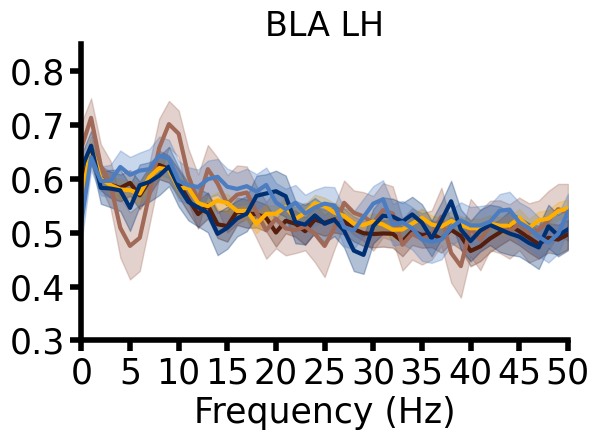

cluster_mean_trial_BLA_MD_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01995201 0.02168295 0.02467541 0.02385156 0.0236479  0.02321809
 0.0228627  0.02148123 0.02057521 0.02055103 0.01908454 0.02128416
 0.02322355 0.02292334 0.02418941 0.02432238 0.02242582 0.0240789
 0.02385235 0.02264732 0.02320004 0.02323015 0.02192459 0.02330263
 0.02215914 0.02100895 0.02314556 0.02194696 0.02085698 0.02131904
 0.02100439 0.02063856 0.02087721 0.02207219 0.02164607 0.02100162
 0.02087338 0.021139   0.02302411 0.02242754 0.02206392 0.02318428
 0.02319009 0.02280025 0.02350951 0.0215457  0.02112949 0.02251402
 0.02268275 0.02197567 0.02285037]
lose_no_comp
(15, 56)
[0.05146326 0.04197837 0.04308458 0.04620738 0.05685399 0.05681249
 0.05346439 0.04296462 0.03761559 0.03274286 0.03490438 0.04492425
 0.04273449 0.03854979 0.04143057 0.04191824 0.04047539 0.04065469
 0.04548115 0.04335973 0.04318045 0.04923458 0.04968805 0.04729869
 0.05093625 0.05353012 0.04753365 0.04119088 0.034

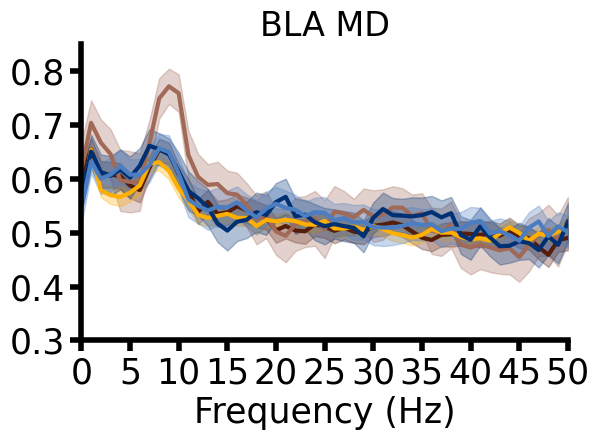

cluster_mean_trial_BLA_mPFC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01966689 0.01849571 0.02169439 0.02071315 0.01981556 0.0184579
 0.01615549 0.01591958 0.01504092 0.01718951 0.01837448 0.02011175
 0.02191897 0.02023527 0.01985005 0.02130421 0.01927749 0.0188384
 0.01716563 0.01975501 0.01930218 0.01975319 0.01662525 0.02034127
 0.01873641 0.01828888 0.02015805 0.02018593 0.01815502 0.01980358
 0.0204225  0.01985115 0.020446   0.02080078 0.01968782 0.02040416
 0.02052768 0.02049862 0.02241384 0.02277015 0.02253177 0.02314089
 0.02251645 0.02287203 0.02329641 0.02299372 0.02350975 0.0235179
 0.02269078 0.02433619 0.02361497]
lose_no_comp
(15, 56)
[0.04041599 0.04115801 0.04432388 0.04565179 0.04653588 0.04920514
 0.04754166 0.04231373 0.03827411 0.03799643 0.03818438 0.0318749
 0.03327474 0.03272138 0.04101535 0.04214791 0.04000019 0.03700183
 0.03837865 0.04169462 0.04488361 0.03268815 0.03137792 0.03641676
 0.03707631 0.04203983 0.04271642 0.04172158 0.0474

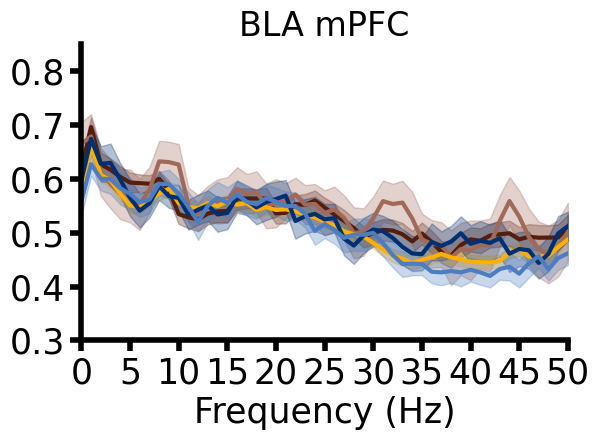

cluster_mean_trial_BLA_vHPC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.02558264 0.02383935 0.02767138 0.02992909 0.03006803 0.02912094
 0.02922102 0.0274097  0.02628933 0.02637189 0.02816827 0.0285743
 0.0278534  0.02835874 0.02820291 0.0282088  0.02949173 0.02828773
 0.02831417 0.03032649 0.02811219 0.02861054 0.02792081 0.02751022
 0.02835796 0.02731626 0.02696875 0.02806556 0.02745989 0.02695521
 0.0271124  0.02709193 0.02722786 0.02810746 0.02814119 0.02834575
 0.0281413  0.02701193 0.02920923 0.02939126 0.02924278 0.02796646
 0.02831384 0.02646063 0.02770178 0.02754371 0.02653124 0.02909538
 0.02877102 0.02978464 0.02890368]
lose_no_comp
(15, 56)
[0.05512918 0.05049941 0.05782354 0.06196162 0.06001025 0.06205573
 0.05687182 0.05692171 0.05382919 0.04957942 0.05214935 0.05956325
 0.05951534 0.06118232 0.05894224 0.05780136 0.05655209 0.05810544
 0.05424076 0.05734449 0.05757898 0.05585769 0.05465796 0.0529666
 0.05708837 0.05707214 0.06293846 0.06305591 0.05

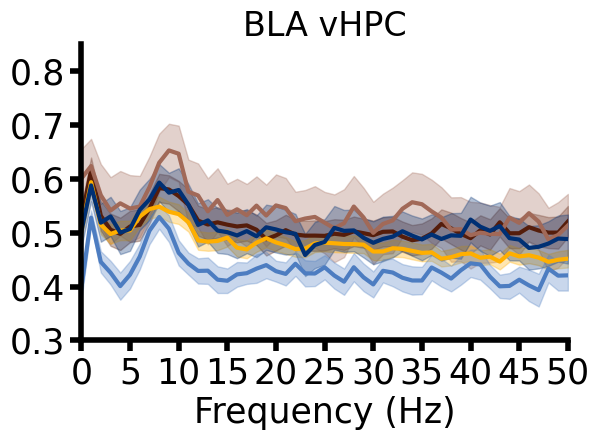

cluster_mean_trial_LH_MD_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.0203082  0.01899278 0.0171159  0.01776968 0.02084045 0.02017265
 0.02173888 0.0232771  0.02626362 0.02658002 0.02641718 0.02540056
 0.02344681 0.02608846 0.02617631 0.02646213 0.0243087  0.02352444
 0.02267415 0.02247248 0.02286202 0.02090099 0.02202749 0.02585798
 0.02334497 0.02239081 0.0217902  0.02232226 0.02291918 0.02521178
 0.02279576 0.02585967 0.02564185 0.02589183 0.0240612  0.02231163
 0.02347197 0.02376843 0.02445773 0.02357435 0.02260517 0.02639952
 0.02483885 0.02369011 0.02352001 0.0237468  0.02294372 0.02285407
 0.02109449 0.02211302 0.02468418]
lose_no_comp
(15, 56)
[0.03097065 0.02469009 0.03621362 0.04654195 0.06382868 0.06510379
 0.05777434 0.05484403 0.04963773 0.0362379  0.04248444 0.04571669
 0.05379142 0.04489771 0.04332929 0.0451935  0.04909996 0.04610651
 0.04339474 0.05419712 0.04892846 0.05039242 0.03635728 0.04322499
 0.05625179 0.0482444  0.05441165 0.05343339 0.050

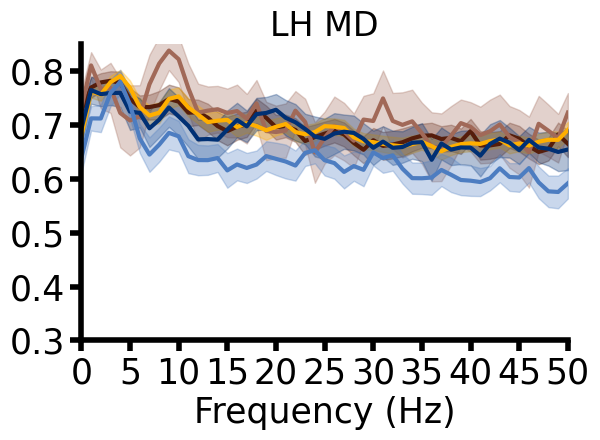

cluster_mean_trial_LH_mPFC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.02001599 0.02053699 0.02075929 0.01891993 0.0190056  0.01741166
 0.0185816  0.01748645 0.01830465 0.01902193 0.01625736 0.01831067
 0.02030808 0.01888034 0.02010995 0.02086566 0.01870355 0.01894313
 0.01890374 0.01839938 0.01655869 0.01902233 0.02335774 0.01959473
 0.01801847 0.01876565 0.0152826  0.01575861 0.01638029 0.01671282
 0.0164591  0.0176853  0.01820949 0.01971059 0.018704   0.02196707
 0.02146978 0.02087126 0.01915259 0.01914641 0.01927012 0.02220781
 0.02321629 0.02080941 0.02147821 0.0226447  0.02043143 0.02116751
 0.02105027 0.01980742 0.0214977 ]
lose_no_comp
(15, 56)
[0.04665504 0.03474522 0.02704357 0.02987978 0.04178024 0.0429983
 0.04530267 0.03726778 0.03343236 0.028182   0.02860176 0.03133593
 0.03277953 0.03013654 0.02197905 0.03408118 0.03592125 0.03021824
 0.02620382 0.03217993 0.03927295 0.04446759 0.04261143 0.03808794
 0.037652   0.03907224 0.03513575 0.03334904 0.03

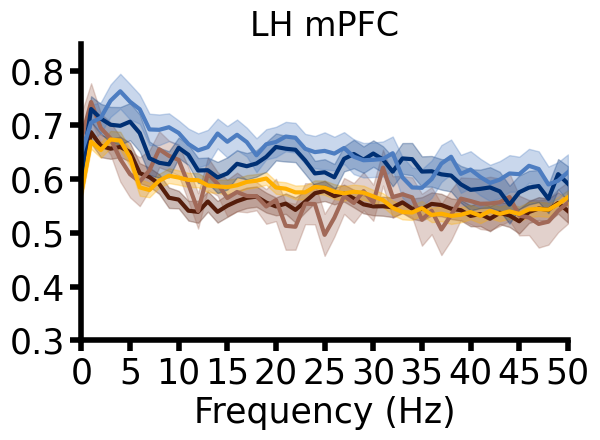

cluster_mean_trial_LH_vHPC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01670226 0.01374235 0.01435414 0.01626954 0.01831814 0.01805879
 0.0188422  0.01900318 0.01760327 0.01986919 0.02084552 0.02056943
 0.01982146 0.01909128 0.01762897 0.01988123 0.01969029 0.01952756
 0.02013631 0.01933345 0.01582857 0.01784741 0.01734456 0.01662886
 0.01691048 0.01812696 0.0194128  0.01986146 0.01774357 0.01566902
 0.01846033 0.02039725 0.01861058 0.01954844 0.0204501  0.02087698
 0.02330883 0.02330473 0.020482   0.02235896 0.02267931 0.02338501
 0.02134134 0.02124235 0.02066553 0.02274135 0.02012632 0.02357441
 0.02167546 0.02322622 0.02355928]
lose_no_comp
(15, 56)
[0.02308468 0.01786398 0.03556536 0.03012192 0.02917054 0.02945708
 0.0302707  0.04690541 0.04614856 0.04706952 0.05317383 0.03990535
 0.04032945 0.04163278 0.04404535 0.03717673 0.04567897 0.03850898
 0.04885277 0.04468947 0.03267038 0.03294121 0.0348543  0.03829423
 0.03432447 0.03741232 0.04508402 0.04149767 0.0

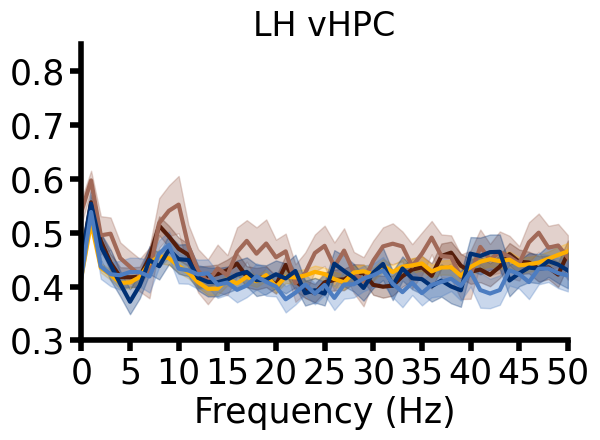

cluster_mean_trial_MD_mPFC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01554528 0.01365875 0.01661691 0.01788388 0.01789123 0.01642187
 0.01685186 0.01604571 0.01494323 0.01380157 0.01385746 0.01406924
 0.0159135  0.01711338 0.01592823 0.01730198 0.01867865 0.01773739
 0.0172192  0.0174533  0.0173898  0.01616001 0.01540222 0.01672921
 0.0154006  0.01522915 0.01484926 0.01370671 0.01447768 0.01587712
 0.01621422 0.01669365 0.01605178 0.01681114 0.01601227 0.01659835
 0.01645585 0.01515008 0.01615493 0.01632911 0.01674969 0.01686389
 0.01720697 0.01633355 0.01641047 0.0154911  0.01549678 0.01527721
 0.01582089 0.01807499 0.01707533]
lose_no_comp
(15, 56)
[0.03552876 0.0344348  0.03113378 0.02682733 0.02688319 0.03243485
 0.03125489 0.03370257 0.02743608 0.0295687  0.02639898 0.03013559
 0.02176233 0.01866824 0.02601994 0.02525539 0.03213801 0.03595798
 0.03169527 0.03218729 0.02595299 0.02944252 0.02910302 0.02546423
 0.02797923 0.02512734 0.0254807  0.03627126 0.0

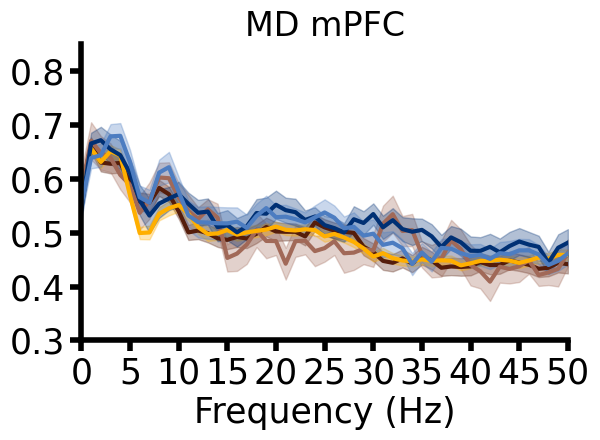

cluster_mean_trial_MD_vHPC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01528409 0.01145358 0.01337952 0.01721874 0.01682565 0.01493408
 0.01489218 0.0147428  0.01402491 0.01534684 0.01470512 0.01424171
 0.01508937 0.01308871 0.01627375 0.01704667 0.01720508 0.01772489
 0.01583372 0.01704708 0.01592525 0.01823067 0.0158643  0.01554708
 0.01561622 0.01567321 0.0173182  0.01696462 0.01689499 0.01609833
 0.01673407 0.01625729 0.01444681 0.01795063 0.01659893 0.01904717
 0.01942004 0.01958633 0.01851628 0.01984401 0.01972865 0.01883506
 0.01854086 0.01768235 0.01761923 0.01868715 0.01830824 0.02090545
 0.02032116 0.02094123 0.0211861 ]
lose_no_comp
(15, 56)
[0.02790116 0.02391448 0.03531093 0.0283499  0.02303969 0.02535783
 0.02862891 0.03397492 0.03593199 0.03193617 0.04358748 0.03253394
 0.02943711 0.02902937 0.0366322  0.03042428 0.02768521 0.03621888
 0.04681374 0.0350813  0.03233275 0.03126716 0.0295999  0.03240668
 0.02412506 0.03022215 0.03489278 0.03525512 0.0

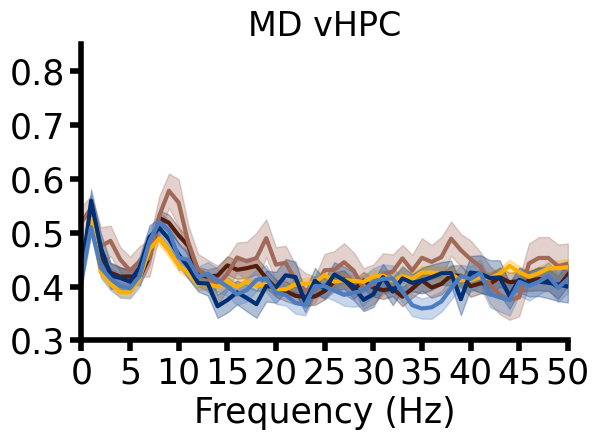

cluster_mean_trial_mPFC_vHPC_coherence_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.01799175 0.01640684 0.01983972 0.02148417 0.02050445 0.01836064
 0.01625542 0.01533946 0.01825852 0.01678007 0.0167472  0.01843314
 0.01856432 0.01830528 0.01768731 0.01720229 0.01809696 0.01734234
 0.01602797 0.01750115 0.01688417 0.01815161 0.01569668 0.01569566
 0.01791808 0.0180738  0.01721941 0.01736921 0.01655665 0.01549578
 0.01617915 0.01695857 0.01734884 0.01906418 0.01888508 0.01961595
 0.02009536 0.01908288 0.01920253 0.02085705 0.02186847 0.02155028
 0.02175073 0.02198489 0.0217315  0.02252382 0.02205446 0.02252711
 0.02254961 0.02460736 0.0245324 ]
lose_no_comp
(15, 56)
[0.04032887 0.02954001 0.03685073 0.0383273  0.0408902  0.04092309
 0.0366148  0.03668445 0.0343639  0.03795914 0.04474571 0.03277059
 0.03684384 0.03674337 0.03685098 0.03281793 0.03813669 0.03328898
 0.03460279 0.03674981 0.040015   0.03644079 0.03673893 0.04020276
 0.04228278 0.04360069 0.04272978 0.0382808  0

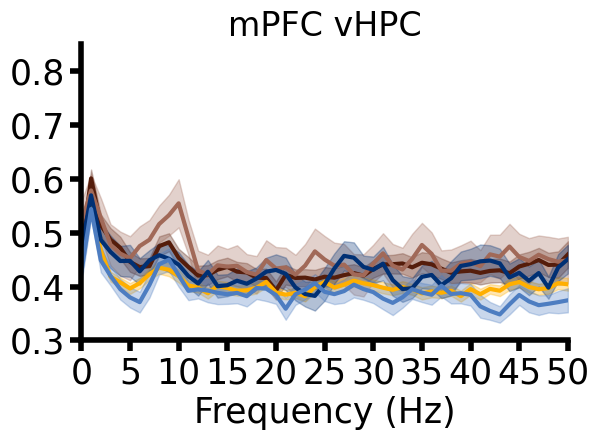

cluster_mean_trial_BLA_LH_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.07347273 0.02698996 0.01792806 0.02613845 0.02119849 0.01800696
 0.02155063 0.02110075 0.01614409 0.01857581 0.02106741 0.01489488
 0.01730493 0.03441744 0.02230168 0.02026369 0.01952127 0.02188626
 0.02373852 0.02545318 0.028841   0.02581997 0.02571061 0.03118263
 0.02691708 0.04357463 0.03244231 0.02948108 0.0342224  0.02756611
 0.03068647 0.02955332 0.01990879 0.02540023 0.02955925 0.03385125
 0.02440198 0.02620338 0.03226929 0.0225339  0.02330725 0.02392857
 0.02493544 0.02928475 0.02837458 0.0261583  0.0225544  0.02632202
 0.01877024 0.023867   0.01679466]
lose_no_comp
(15, 56)
[0.06848745 0.03979377 0.03230892 0.03853843 0.02373976 0.02070186
 0.03912822 0.05827865 0.0645504  0.04994065 0.03704514 0.0524466
 0.04097752 0.06191979 0.04777785 0.06584983 0.04127148 0.06343567
 0.06999298 0.05404859 0.038415   0.03418898 0.0496095  0.05969708
 0.04799761 0.05797794 0.06310904 0.04796853 0.07396

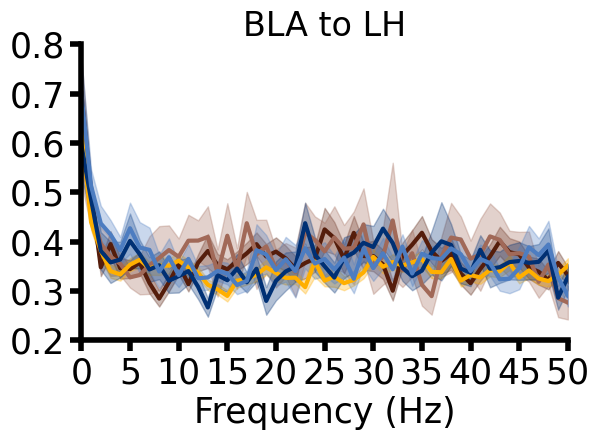

cluster_mean_trial_BLA_MD_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03734832 0.02135262 0.02439579 0.02340216 0.01817789 0.01895546
 0.01955578 0.02276847 0.01946998 0.02497435 0.01876977 0.01869286
 0.01890254 0.02300001 0.02201624 0.01939181 0.02076043 0.02433405
 0.02295427 0.02796492 0.02861175 0.04301726 0.02160782 0.03086903
 0.0232446  0.03210046 0.02166282 0.02054106 0.02602248 0.02758308
 0.01915494 0.0267864  0.01833893 0.02110916 0.03238384 0.01817259
 0.01855587 0.01922113 0.02464907 0.01966784 0.02112404 0.02138652
 0.01796776 0.02684302 0.02100238 0.01767573 0.01885053 0.02702985
 0.02223383 0.02211221 0.01776745]
lose_no_comp
(15, 56)
[0.05550778 0.06570299 0.0412556  0.02881248 0.03128233 0.0271814
 0.05939521 0.03579185 0.06136185 0.05716516 0.05561092 0.07789644
 0.05087305 0.06580052 0.07903014 0.0602585  0.05129417 0.03966935
 0.0419529  0.0568475  0.03960291 0.05356922 0.07368927 0.04817627
 0.04258499 0.04547077 0.03098231 0.04364471 0.06257

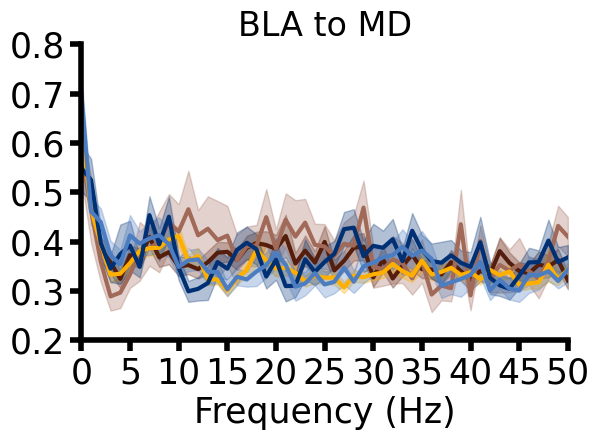

cluster_mean_trial_BLA_mPFC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03554974 0.02253776 0.02518376 0.02950797 0.02350659 0.02329759
 0.02542726 0.02482076 0.02688316 0.02430192 0.01890068 0.01907948
 0.0265819  0.02966053 0.01772396 0.01973864 0.02290308 0.02097033
 0.02279729 0.02531504 0.03311225 0.02198717 0.01897637 0.02776708
 0.02367156 0.0324044  0.02120398 0.02103715 0.02107298 0.02325442
 0.02094275 0.02379432 0.02189982 0.02688755 0.02377015 0.03068366
 0.02745804 0.02583988 0.02300602 0.0252299  0.02471738 0.02351183
 0.02869226 0.02829099 0.02033877 0.02616042 0.02135103 0.02810911
 0.02220308 0.02183796 0.02309267]
lose_no_comp
(15, 56)
[0.05953926 0.05444831 0.0411053  0.05362532 0.0822587  0.09187609
 0.0902371  0.0608136  0.06609742 0.04430359 0.02920395 0.07071924
 0.03868343 0.11670693 0.04792583 0.06684652 0.04905954 0.04660305
 0.06532272 0.05046294 0.04876166 0.06193809 0.04947529 0.05628013
 0.04072003 0.05225383 0.04971145 0.05729735 0.03

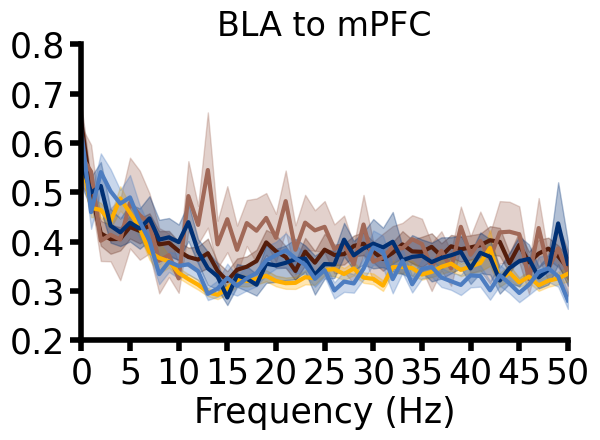

cluster_mean_trial_BLA_vHPC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04101551 0.02954694 0.0195976  0.04019847 0.01921386 0.01787607
 0.01989371 0.03044628 0.02527873 0.03312827 0.03354961 0.04222731
 0.0407073  0.03339306 0.0273777  0.03940798 0.03025803 0.03416464
 0.02663228 0.03155291 0.02903448 0.02751169 0.02466639 0.02499416
 0.0243972  0.03576826 0.02581382 0.02541114 0.02926364 0.02461949
 0.02133058 0.02798538 0.02288424 0.02439737 0.02140288 0.02716555
 0.02301563 0.0222188  0.02606644 0.02670902 0.02521034 0.02253606
 0.01772132 0.01905404 0.01989657 0.02163895 0.01764185 0.02099421
 0.01559778 0.01375094 0.02137619]
lose_no_comp
(15, 56)
[0.07138797 0.0363697  0.02921149 0.02608065 0.05005074 0.04049399
 0.03858022 0.04047649 0.03616692 0.05394481 0.08193537 0.06191564
 0.06844673 0.06868421 0.04739336 0.08184716 0.05521858 0.04856264
 0.03305868 0.06840576 0.07661771 0.09995081 0.04673585 0.05050335
 0.03928063 0.03818191 0.04840777 0.04340697 0.04

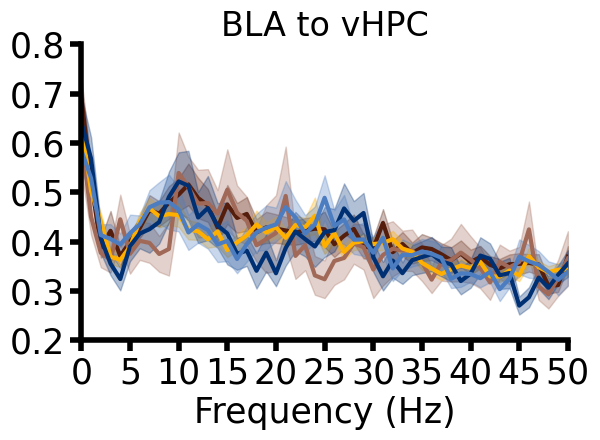

cluster_mean_trial_LH_BLA_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04535808 0.03163937 0.03049924 0.01721354 0.03177525 0.02805192
 0.0255361  0.02052066 0.02100462 0.01805326 0.02340969 0.0171085
 0.01800934 0.01263082 0.01845878 0.01636099 0.01592185 0.019152
 0.01647319 0.01466449 0.01534136 0.01432149 0.020931   0.0189317
 0.02192202 0.01562136 0.04366057 0.01640017 0.01939262 0.01413393
 0.02602856 0.01694181 0.01470497 0.01523981 0.02236533 0.01547934
 0.01912103 0.0148249  0.01774842 0.01721213 0.02016505 0.01636307
 0.01579862 0.01577689 0.02142115 0.01418881 0.01638272 0.01695158
 0.01539857 0.01762483 0.01506313]
lose_no_comp
(15, 56)
[0.07440341 0.13156398 0.03655848 0.0358235  0.0312754  0.04388853
 0.05720939 0.02772257 0.06178774 0.03798335 0.05025516 0.06181293
 0.0311898  0.02694821 0.03094551 0.04471235 0.06307297 0.09359482
 0.05619035 0.03324574 0.02738025 0.02869237 0.04792154 0.03368291
 0.0218495  0.02225852 0.03193888 0.03947486 0.02872144

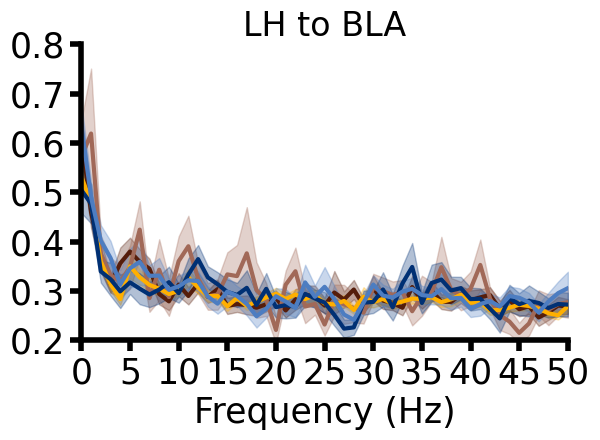

cluster_mean_trial_LH_MD_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04632327 0.02782581 0.02353303 0.02187579 0.03449616 0.02244671
 0.02145386 0.02962461 0.02461332 0.02437078 0.02919976 0.02114866
 0.02191987 0.01912072 0.01775088 0.01743602 0.01928761 0.01979926
 0.01935226 0.02275774 0.02419914 0.02334414 0.01513718 0.01944418
 0.01471961 0.01650143 0.01655338 0.01601377 0.01599831 0.01566528
 0.01356527 0.01826982 0.01826489 0.01285225 0.01582922 0.01484384
 0.01771444 0.01930933 0.01480429 0.01550038 0.01433798 0.01800873
 0.01466531 0.01552616 0.01633934 0.02252118 0.02058815 0.02291462
 0.01477181 0.01729685 0.0146632 ]
lose_no_comp
(15, 56)
[0.12889451 0.09175579 0.02531138 0.04669777 0.02795725 0.05158285
 0.04617615 0.05473917 0.05121337 0.04256345 0.05655057 0.05985195
 0.036836   0.05334839 0.03869805 0.0685146  0.02802419 0.02805976
 0.04064889 0.0426636  0.03530807 0.04352229 0.03207169 0.04644081
 0.02621115 0.04987913 0.02427424 0.05044061 0.02250

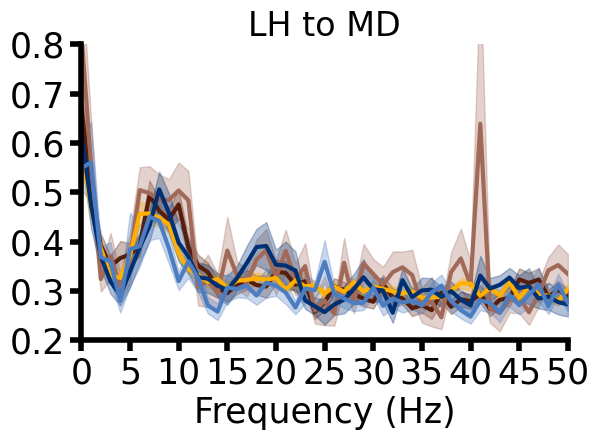

cluster_mean_trial_LH_mPFC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03508717 0.0277929  0.02246615 0.03389462 0.03161432 0.02821366
 0.02944359 0.03945864 0.02746835 0.02255282 0.01674736 0.01697545
 0.02049935 0.01525506 0.01967004 0.01801831 0.01557269 0.01398666
 0.02140704 0.01777316 0.02604747 0.01727614 0.01443153 0.02008348
 0.01842059 0.0194238  0.02468195 0.0180501  0.02011    0.01528066
 0.01723005 0.01839689 0.02107285 0.01914685 0.01773398 0.01773465
 0.01897199 0.01389676 0.01789133 0.01780418 0.01988971 0.01996941
 0.0192458  0.0160828  0.02042331 0.02235381 0.0261515  0.01694915
 0.01977174 0.02526444 0.03217907]
lose_no_comp
(15, 56)
[0.07167092 0.06243927 0.03245351 0.0859359  0.03544599 0.08372827
 0.06002554 0.06502385 0.05300267 0.04962739 0.08350466 0.0325922
 0.0334111  0.02539143 0.02493975 0.07793298 0.03128068 0.06112945
 0.02634048 0.06071432 0.05525669 0.03901464 0.02137039 0.06476604
 0.0192992  0.03969874 0.01897146 0.04576049 0.0312

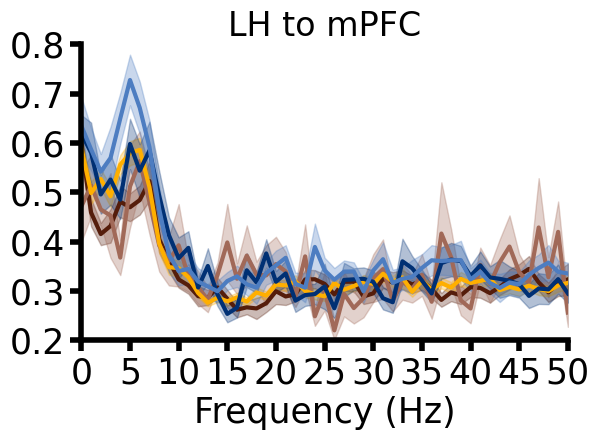

cluster_mean_trial_LH_vHPC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04367794 0.02677397 0.02711221 0.023588   0.01587467 0.01940077
 0.0218278  0.02525313 0.02550529 0.02158765 0.03953126 0.02363445
 0.0190192  0.02323887 0.01874628 0.01722206 0.02002423 0.01962458
 0.01775256 0.02193286 0.01808536 0.02183825 0.02163901 0.01805098
 0.01575479 0.01618275 0.0196839  0.0207094  0.01385388 0.01576325
 0.01626358 0.01837189 0.02440836 0.01778616 0.02731188 0.04243537
 0.03383359 0.0177605  0.01886042 0.01736436 0.01706049 0.04389841
 0.0279199  0.01661534 0.01999378 0.04236392 0.01692848 0.02106998
 0.02033144 0.01736015 0.01483735]
lose_no_comp
(15, 56)
[0.05159526 0.04556325 0.04108943 0.02689241 0.04120832 0.04392942
 0.04557486 0.02738494 0.03965638 0.04134505 0.04117618 0.07885283
 0.03302985 0.03961454 0.04201072 0.02825367 0.02439414 0.03537922
 0.03226548 0.02356907 0.02653095 0.02655373 0.0524974  0.04311427
 0.03145077 0.02322962 0.01634055 0.02994747 0.023

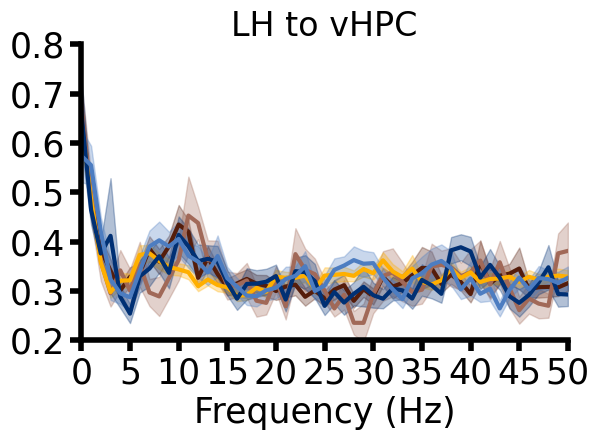

cluster_mean_trial_MD_BLA_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.02973162 0.02729197 0.03042685 0.01421852 0.01880966 0.01815809
 0.02409306 0.02074329 0.01850388 0.01871238 0.01835981 0.01410914
 0.01677411 0.01391884 0.01842354 0.01246463 0.01936676 0.01535319
 0.01592476 0.01588823 0.01275513 0.01112994 0.01271344 0.0145559
 0.01608175 0.01457185 0.01334059 0.01426195 0.01146194 0.01564444
 0.01385227 0.01406148 0.0179879  0.01872247 0.0162084  0.01539417
 0.01496981 0.01614512 0.01323321 0.01802243 0.01689069 0.01479599
 0.01489118 0.01925101 0.01313384 0.01440581 0.01332521 0.01944415
 0.01482338 0.01730761 0.01328729]
lose_no_comp
(15, 56)
[0.06256439 0.04571462 0.03611077 0.03677185 0.06287599 0.05869021
 0.04006549 0.04965431 0.07156793 0.05872251 0.04707034 0.03937973
 0.03251741 0.03133446 0.02870481 0.02303969 0.03747488 0.01799368
 0.02440197 0.01450213 0.01984198 0.03385057 0.03012602 0.03073322
 0.03529637 0.02093979 0.03132483 0.03922757 0.01540

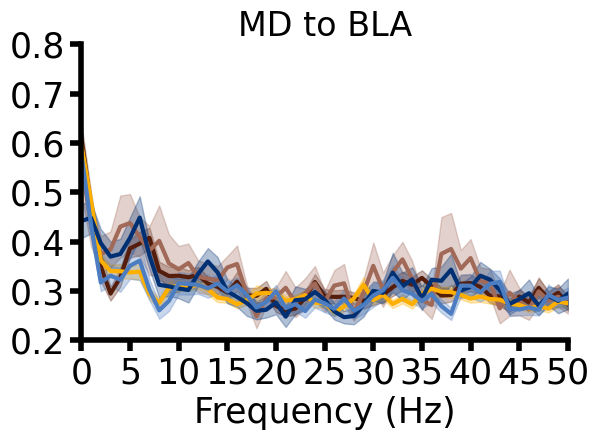

cluster_mean_trial_MD_LH_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04663007 0.02437294 0.01950869 0.01801363 0.02196657 0.02314507
 0.02294148 0.02465261 0.01976805 0.02294841 0.01737398 0.04665692
 0.01669588 0.02303795 0.01906612 0.01927968 0.01732511 0.01633326
 0.01759498 0.01973865 0.01966966 0.0166322  0.01967255 0.01627785
 0.01959524 0.012685   0.01325602 0.01790893 0.0176794  0.01289118
 0.01574688 0.04865474 0.01275731 0.01407326 0.01753514 0.01986507
 0.01269338 0.01594622 0.01211284 0.03499167 0.01423154 0.01793421
 0.01581863 0.01460319 0.01492376 0.01887113 0.02377661 0.01938624
 0.01609411 0.02972207 0.0149525 ]
lose_no_comp
(15, 56)
[0.11598141 0.03459172 0.03394824 0.02854918 0.01803611 0.04155669
 0.07827636 0.08154897 0.11399977 0.04740548 0.04610642 0.02924019
 0.03512744 0.0513284  0.03210455 0.03258965 0.02831967 0.02960989
 0.04206938 0.02523738 0.03759088 0.03228501 0.03061643 0.0569078
 0.04474772 0.0299415  0.02426501 0.03746857 0.031480

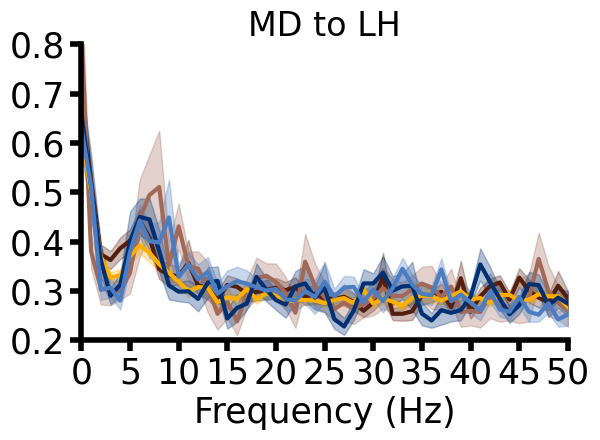

cluster_mean_trial_MD_mPFC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03046713 0.01920504 0.01391709 0.02058793 0.02253771 0.02247742
 0.02950541 0.03404853 0.02752194 0.02058235 0.01933656 0.01698095
 0.01733028 0.01250925 0.01576509 0.01394738 0.0140192  0.01276338
 0.01244703 0.01777353 0.0121992  0.00989765 0.01290724 0.01425533
 0.01461243 0.01150193 0.0139176  0.01469932 0.01358906 0.01378118
 0.01583737 0.01167836 0.0150368  0.0145921  0.01304656 0.01623096
 0.01390512 0.01421122 0.01380213 0.01374682 0.01347632 0.01636821
 0.01732355 0.01607543 0.02518466 0.0137342  0.01455901 0.01583011
 0.01281637 0.01337026 0.01657523]
lose_no_comp
(15, 56)
[0.0943568  0.03623753 0.03050346 0.05282045 0.03731627 0.07732512
 0.05696329 0.05372456 0.04173195 0.04009451 0.02777966 0.01798011
 0.023732   0.02756347 0.02963771 0.03957308 0.03067294 0.030833
 0.02825929 0.0336122  0.03392457 0.03297705 0.02304397 0.03231822
 0.02097481 0.02305464 0.02532166 0.03387921 0.03105

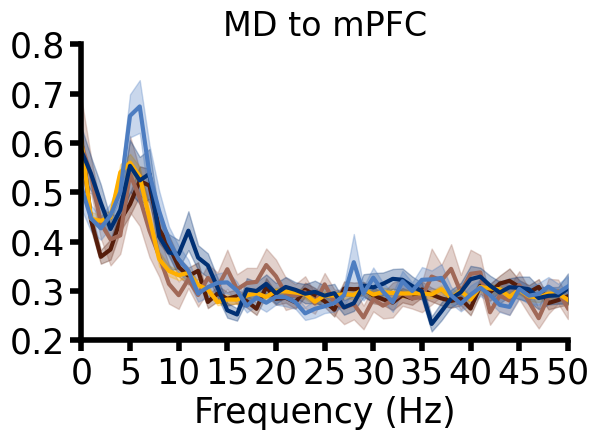

cluster_mean_trial_MD_vHPC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03354293 0.0215758  0.01824955 0.01604934 0.01499061 0.02208449
 0.01992051 0.02637339 0.02565338 0.0250873  0.02561229 0.02595158
 0.01922996 0.01765675 0.01836476 0.02017972 0.02430902 0.02126192
 0.01490661 0.01791363 0.02055077 0.01811589 0.02210699 0.01834953
 0.01550629 0.01439776 0.01539092 0.01814089 0.01923776 0.0153448
 0.01481362 0.0164743  0.01772211 0.02179115 0.01796475 0.01594576
 0.01368992 0.01329589 0.01531066 0.01756321 0.02007652 0.01998799
 0.01797679 0.01691572 0.01647652 0.0154072  0.01478504 0.01484659
 0.0152225  0.01341205 0.0129883 ]
lose_no_comp
(15, 56)
[0.05727827 0.03235638 0.03702543 0.03342442 0.04355374 0.0414529
 0.0469901  0.04060764 0.03950748 0.03435997 0.04258335 0.0508868
 0.03987093 0.03774281 0.03798984 0.05008281 0.0346727  0.04594883
 0.02887388 0.01955314 0.01822318 0.03083854 0.03542857 0.03937889
 0.02204233 0.02392583 0.01364406 0.02587118 0.026444

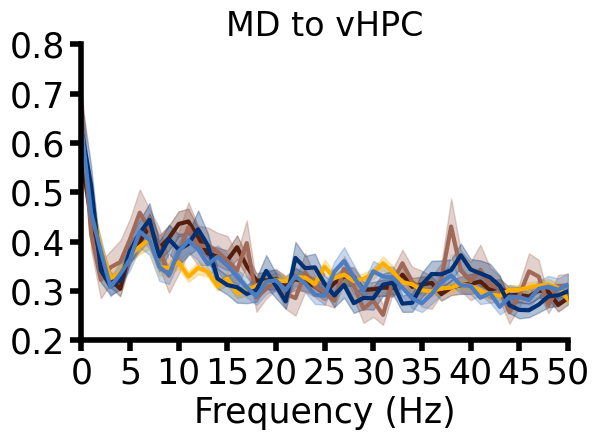

cluster_mean_trial_mPFC_BLA_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03514091 0.02120304 0.0207671  0.02252636 0.0196457  0.01766507
 0.01714801 0.02334095 0.0137879  0.0155027  0.02116431 0.01393767
 0.0125525  0.01359901 0.01460098 0.01349866 0.01511758 0.01552069
 0.01197257 0.01650396 0.01527502 0.01522486 0.01681596 0.01472122
 0.01489459 0.0120798  0.01491512 0.0152311  0.01306149 0.01383185
 0.01171456 0.01730164 0.02580462 0.01235196 0.01236756 0.01371841
 0.02211798 0.01501681 0.01684395 0.01670574 0.01404134 0.01726859
 0.01237869 0.01493647 0.01411251 0.01186381 0.01571617 0.02365035
 0.01521812 0.01201515 0.01376938]
lose_no_comp
(15, 56)
[0.07927299 0.07801898 0.01858689 0.02794921 0.02701496 0.04265801
 0.02494469 0.02507662 0.02887471 0.02482789 0.03778722 0.02013105
 0.01881922 0.02559779 0.02760463 0.03782493 0.02715432 0.03833294
 0.03140805 0.0193422  0.02183838 0.02714075 0.03084471 0.02904793
 0.03295534 0.02578655 0.01772229 0.04032572 0.02

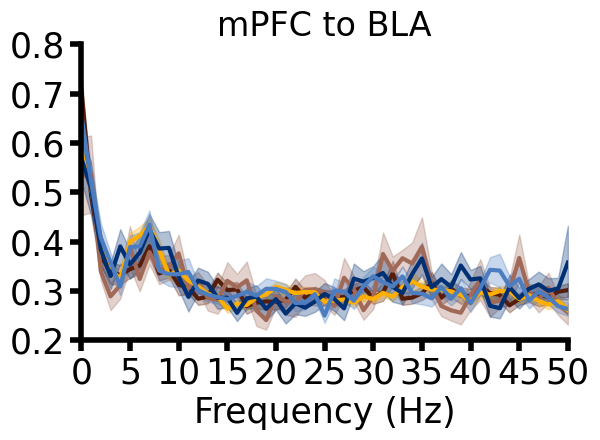

cluster_mean_trial_mPFC_LH_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04190729 0.02703143 0.02242353 0.02690486 0.02126551 0.0254031
 0.04272396 0.02507766 0.0229245  0.02184153 0.02081133 0.01914687
 0.02290147 0.02292378 0.0194813  0.01837944 0.02066572 0.01472016
 0.01872226 0.01665786 0.01625763 0.01787878 0.01944668 0.02008759
 0.01959051 0.01593938 0.02398833 0.0152613  0.0152839  0.01704518
 0.02161405 0.01778023 0.01248215 0.01793831 0.01439312 0.03412681
 0.02047217 0.01599329 0.01649805 0.01632641 0.01943976 0.01572186
 0.02066786 0.01569106 0.01705172 0.02206055 0.01686067 0.01714112
 0.01485062 0.01678171 0.02390227]
lose_no_comp
(15, 56)
[0.06148938 0.04523377 0.03135046 0.02728733 0.02079952 0.0422452
 0.0299914  0.05424957 0.03768661 0.05981113 0.05558832 0.0533484
 0.02964886 0.05770734 0.01928962 0.01962021 0.02622531 0.02465283
 0.027461   0.10110783 0.02349734 0.06497003 0.01860437 0.0276565
 0.02553145 0.07152412 0.02537717 0.02734668 0.0257465

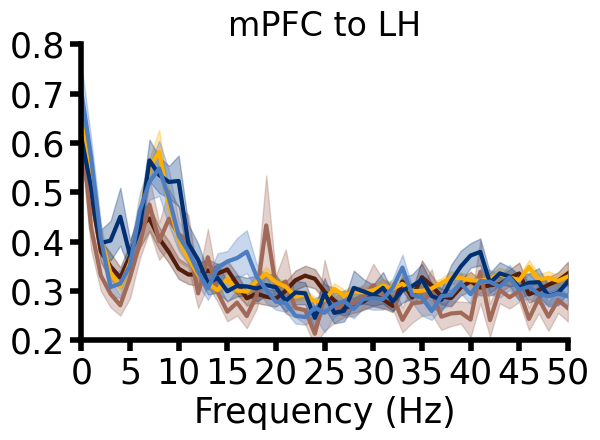

cluster_mean_trial_mPFC_MD_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03420201 0.02401302 0.01785616 0.01476362 0.01353026 0.01937961
 0.02621639 0.03549673 0.03157848 0.02536967 0.02099032 0.01637848
 0.0116486  0.0139819  0.01250308 0.01644509 0.02186501 0.01546876
 0.01405862 0.0159319  0.01671494 0.01762947 0.01647669 0.01172618
 0.01263424 0.01045602 0.01373044 0.01312478 0.01299457 0.01405289
 0.01040446 0.01360061 0.01815103 0.01399063 0.01510188 0.01454538
 0.01368865 0.01344977 0.01244888 0.01196242 0.01747217 0.01356297
 0.01308917 0.02025739 0.01773616 0.0173433  0.0178178  0.01580569
 0.0165096  0.01671155 0.01407098]
lose_no_comp
(15, 56)
[0.05242741 0.03164093 0.03967032 0.03609175 0.0345058  0.03574473
 0.04355944 0.06885939 0.03733065 0.05699261 0.0368092  0.03759254
 0.03917679 0.01804513 0.01795193 0.02460624 0.03273872 0.02626679
 0.02580328 0.02295629 0.02344022 0.01634565 0.02580053 0.03128542
 0.02303399 0.02306194 0.03303217 0.02948787 0.027

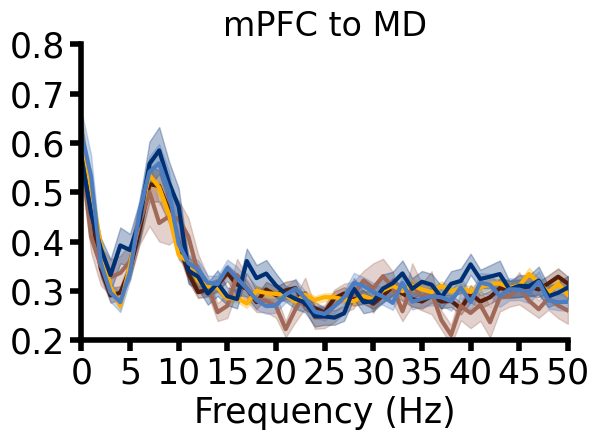

cluster_mean_trial_mPFC_vHPC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03242339 0.02344237 0.01712619 0.01819612 0.01690875 0.01872887
 0.01710353 0.02481518 0.01845154 0.01581182 0.02110337 0.01784983
 0.01953721 0.01396722 0.01728092 0.01863976 0.01644862 0.01618909
 0.01491345 0.01523575 0.01840967 0.01913205 0.0170475  0.01671961
 0.01532975 0.01442767 0.01613489 0.01312068 0.01594884 0.01454172
 0.01374488 0.01351083 0.01423661 0.01549671 0.01774933 0.01320758
 0.02091912 0.01549449 0.01788867 0.01510009 0.01359681 0.01363933
 0.01435412 0.01559129 0.01449993 0.01708783 0.01403292 0.0144405
 0.01538447 0.0171412  0.01335537]
lose_no_comp
(15, 56)
[0.04392317 0.03707846 0.02095066 0.0277505  0.03171436 0.02725611
 0.0393937  0.03127847 0.02489469 0.02414262 0.03504264 0.03029286
 0.03673628 0.02335407 0.02550639 0.04582025 0.03916917 0.03216714
 0.0178674  0.01926769 0.01925434 0.03063642 0.0349568  0.03964972
 0.03322912 0.03779375 0.02129867 0.03252502 0.02

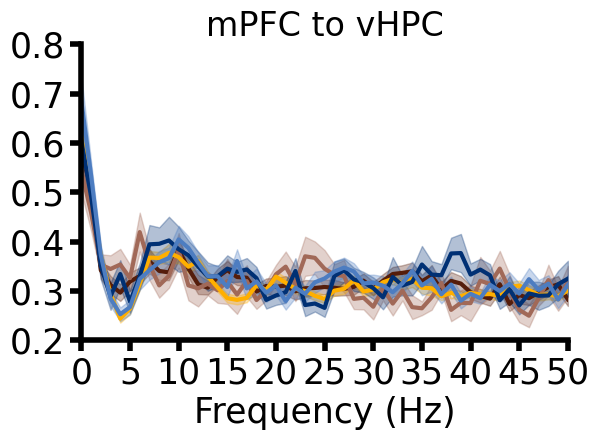

cluster_mean_trial_vHPC_BLA_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.03691057 0.02516309 0.02564778 0.01678317 0.02376125 0.02596181
 0.03315241 0.02994891 0.02769812 0.02416806 0.02084121 0.0240419
 0.02061938 0.02595494 0.02290276 0.02231219 0.01597004 0.0239676
 0.01931603 0.0198396  0.02102934 0.02107562 0.02366602 0.01968394
 0.01839346 0.01897864 0.01802284 0.01911468 0.01757981 0.02138359
 0.02022729 0.02014046 0.0186046  0.02795662 0.02119466 0.02301429
 0.02815267 0.02872329 0.02113017 0.02291656 0.02274474 0.02658822
 0.03124332 0.03031726 0.02628967 0.02748146 0.02310183 0.02621327
 0.02283367 0.02599329 0.02036864]
lose_no_comp
(15, 56)
[0.05014416 0.04894917 0.02164382 0.02481256 0.02748203 0.05068609
 0.03266213 0.03814097 0.05583087 0.04547119 0.04096315 0.05637445
 0.02132348 0.02539596 0.05278062 0.03110886 0.03596282 0.02188987
 0.04515911 0.03474605 0.06968409 0.04349411 0.03836744 0.04244938
 0.02557535 0.03041834 0.04733008 0.06059438 0.0328

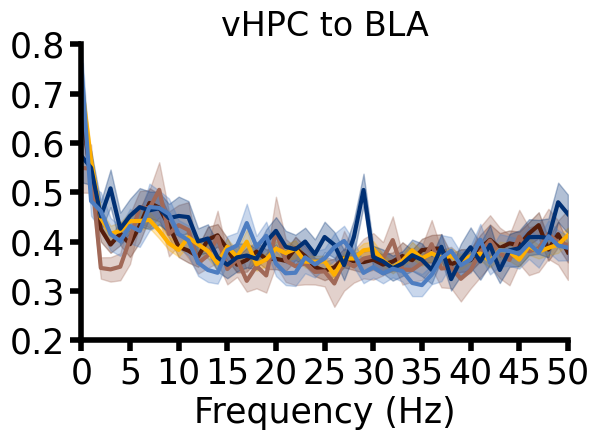

cluster_mean_trial_vHPC_LH_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.05566397 0.03931996 0.0232554  0.0315002  0.02221344 0.023112
 0.02076079 0.02629141 0.02085552 0.0203744  0.0237855  0.01451823
 0.0188196  0.02381203 0.02100528 0.02701941 0.02741264 0.0433592
 0.02490062 0.01972233 0.02473733 0.02728252 0.02004905 0.02692766
 0.02078965 0.03247366 0.02263901 0.03039127 0.01882834 0.0329868
 0.02640227 0.02342287 0.02186447 0.0210195  0.02754913 0.02350268
 0.02010069 0.02297988 0.02043648 0.03012566 0.01731702 0.02250083
 0.01817382 0.01555948 0.01612607 0.02204172 0.01859345 0.02300924
 0.01570976 0.01875869 0.01570416]
lose_no_comp
(15, 56)
[0.09355502 0.06793824 0.06072678 0.05610381 0.06041826 0.04091891
 0.03066237 0.05018233 0.0420173  0.04956587 0.04368662 0.03609443
 0.02669706 0.04248234 0.03830337 0.03585482 0.05922431 0.05034258
 0.0422655  0.04017621 0.03156284 0.02708898 0.03411849 0.02780674
 0.04936071 0.04288463 0.06261728 0.05145027 0.0447293

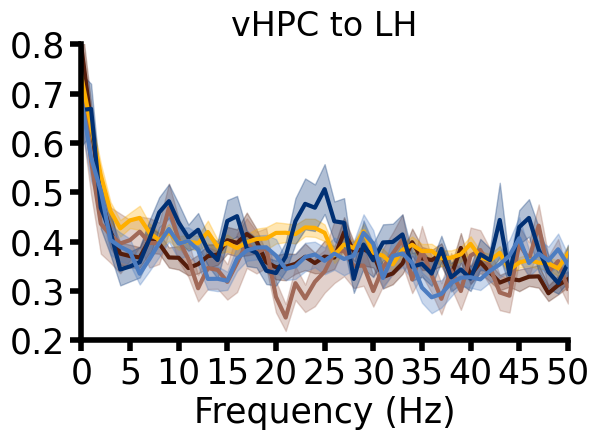

cluster_mean_trial_vHPC_MD_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.04006317 0.02473412 0.02684107 0.01998933 0.02331996 0.0191365
 0.02183737 0.02421018 0.02957721 0.02600014 0.0272829  0.01763772
 0.01700878 0.02168588 0.01777328 0.01775358 0.02092811 0.02457196
 0.01715132 0.02527583 0.02196713 0.02157755 0.01447203 0.01917947
 0.02120306 0.0229745  0.01713942 0.01798076 0.01775737 0.01824802
 0.02257046 0.0211737  0.0232246  0.01939825 0.01827461 0.01689766
 0.01613377 0.01610013 0.01619551 0.01922834 0.01533739 0.01791718
 0.02036598 0.01145634 0.0162369  0.01797973 0.01557279 0.01573399
 0.01576194 0.0220945  0.01402942]
lose_no_comp
(15, 56)
[0.10481712 0.07662556 0.07018612 0.04812194 0.06568796 0.04022391
 0.03402652 0.05952752 0.05626221 0.07720223 0.06602085 0.06628612
 0.04538546 0.05473805 0.04122714 0.04027147 0.03727069 0.02478572
 0.03804126 0.03366805 0.03181203 0.04320459 0.03412057 0.02691867
 0.03446152 0.06808045 0.0636787  0.03037643 0.0409

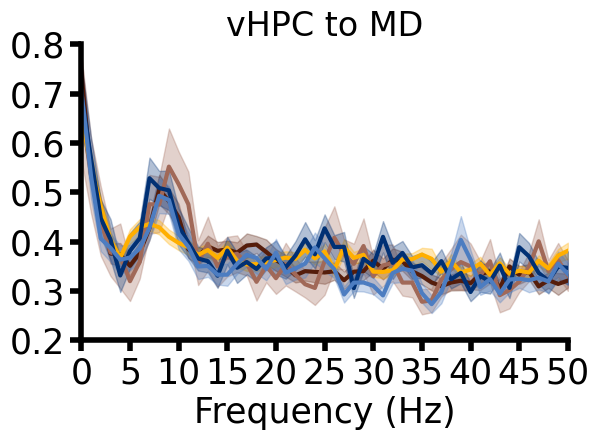

cluster_mean_trial_vHPC_mPFC_granger_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.0373537  0.03189751 0.03140594 0.02739304 0.02706145 0.02068709
 0.0226481  0.02408702 0.01888694 0.01812574 0.01943006 0.01591618
 0.01772099 0.01880606 0.01988905 0.02249347 0.02328139 0.02112237
 0.02079975 0.01727637 0.02276324 0.02269987 0.02232993 0.02364489
 0.02111951 0.01776305 0.02267123 0.0226446  0.02195518 0.02069267
 0.01762663 0.01653224 0.02045421 0.0383367  0.01729159 0.0256007
 0.0412151  0.02170445 0.02367351 0.01847893 0.01968973 0.02032531
 0.02256447 0.02491002 0.01831093 0.02018492 0.02036753 0.0219023
 0.0195739  0.01984619 0.01960976]
lose_no_comp
(15, 56)
[0.08630548 0.04582066 0.05284323 0.04826828 0.07218815 0.05874011
 0.05221326 0.03421471 0.03850498 0.03771303 0.03083888 0.03994381
 0.03477403 0.03354736 0.04165723 0.0490456  0.06026249 0.03362326
 0.03705673 0.02961854 0.03507106 0.02753322 0.03018478 0.03552512
 0.04923217 0.04387897 0.03969714 0.02510746 0.069

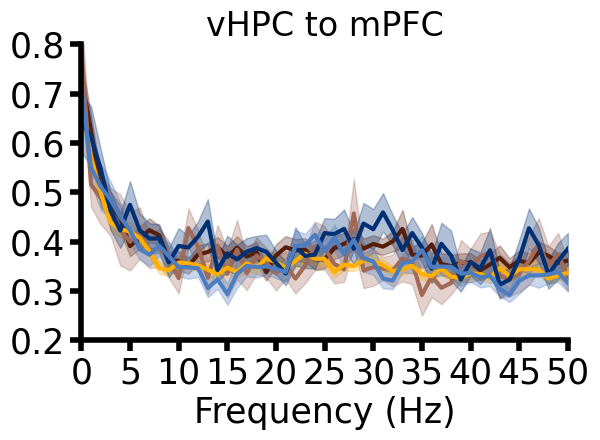

cluster_mean_trial_BLA_power_all_frequencies_all_windows
lose_competitive
(60, 56)
[0.00044401 0.00048117 0.00079064 0.00110726 0.00111673 0.00106186
 0.00122793 0.00142597 0.00141099 0.00123001 0.00100763 0.00071749
 0.00051407 0.00039982 0.00032166 0.00029994 0.00026772 0.00026192
 0.00026048 0.00023679 0.00022549 0.00021153 0.00019425 0.00019654
 0.00020206 0.00020323 0.00020377 0.00019697 0.00019936 0.000204
 0.00021525 0.0002328  0.00024056 0.00024934 0.00026065 0.00031161
 0.00032996 0.00034136 0.00034679 0.00034225 0.00036299 0.00036104
 0.00034921 0.00032386 0.00028727 0.00027608 0.00024995 0.0002152
 0.00019236 0.00016751 0.00015283]
lose_no_comp
(15, 56)
[0.00156119 0.00129351 0.00170544 0.00174199 0.00211043 0.00210397
 0.00219868 0.00297009 0.00364599 0.00408265 0.00330651 0.00185498
 0.00086779 0.00063821 0.00051554 0.00040105 0.00041322 0.00041048
 0.00044482 0.00038239 0.00037308 0.00040034 0.00038804 0.00035496
 0.0003862  0.00031822 0.00034063 0.00036669 0.00039276 0.0

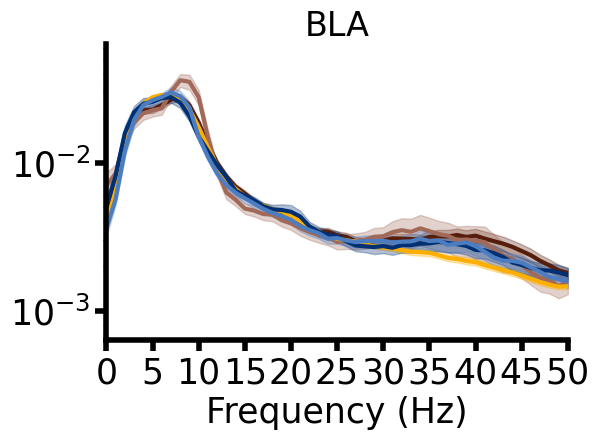

cluster_mean_trial_LH_power_all_frequencies_all_windows
lose_competitive
(60, 56)
[3.76481856e-04 5.34103830e-04 8.57812557e-04 1.10854615e-03
 1.17188970e-03 1.01689957e-03 1.01419913e-03 1.19403786e-03
 1.69914559e-03 1.74134048e-03 1.47613820e-03 8.57730919e-04
 4.74716461e-04 3.10725583e-04 2.30487713e-04 2.06159737e-04
 2.08863557e-04 2.00752097e-04 2.07035621e-04 2.04551467e-04
 1.92885117e-04 1.70512554e-04 1.58405939e-04 1.46774352e-04
 1.39422526e-04 1.25311676e-04 1.11861718e-04 1.13681163e-04
 1.13224179e-04 1.07388832e-04 1.00271588e-04 9.84971640e-05
 9.17903516e-05 9.11216370e-05 9.30008523e-05 8.74104731e-05
 7.40395763e-05 6.78406893e-05 6.92041491e-05 7.18941121e-05
 6.70427014e-05 6.57893376e-05 5.97602274e-05 5.90148978e-05
 5.49820575e-05 5.04859848e-05 4.73815516e-05 4.89454703e-05
 4.92976559e-05 5.02728413e-05 5.90403422e-05]
lose_no_comp
(15, 56)
[5.47342891e-04 6.38435371e-04 1.64544402e-03 1.81367038e-03
 2.03522511e-03 2.59101234e-03 3.27695036e-03 4.38854021

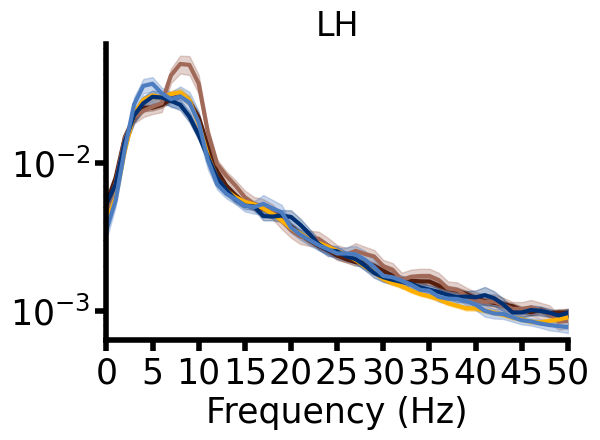

cluster_mean_trial_MD_power_all_frequencies_all_windows
lose_competitive
(60, 56)
[5.41532680e-04 5.43211317e-04 8.76974608e-04 1.13655556e-03
 1.28996077e-03 1.17367961e-03 1.16269943e-03 1.70003724e-03
 2.35882587e-03 2.50230066e-03 2.13693353e-03 1.30307870e-03
 5.97802432e-04 3.32869598e-04 2.28736216e-04 2.02703678e-04
 2.07517952e-04 2.21302751e-04 2.29841595e-04 2.25319428e-04
 2.28601645e-04 1.92130849e-04 1.46095725e-04 1.23619484e-04
 1.17362118e-04 1.33970294e-04 1.26379745e-04 1.16322221e-04
 1.14104263e-04 1.03927513e-04 1.04446319e-04 9.59699667e-05
 8.64538675e-05 8.36982346e-05 7.76625191e-05 7.54868688e-05
 7.78638196e-05 7.99481001e-05 8.35272404e-05 7.75057425e-05
 7.74871589e-05 6.98176467e-05 7.61648339e-05 7.42259904e-05
 6.25971717e-05 5.32819221e-05 5.03669313e-05 5.10919865e-05
 5.04368131e-05 5.54279499e-05 8.62204121e-05]
lose_no_comp
(15, 56)
[0.0013773  0.00113032 0.00166693 0.00175171 0.00225276 0.00234022
 0.00299863 0.00473481 0.00707385 0.0077797  0.006

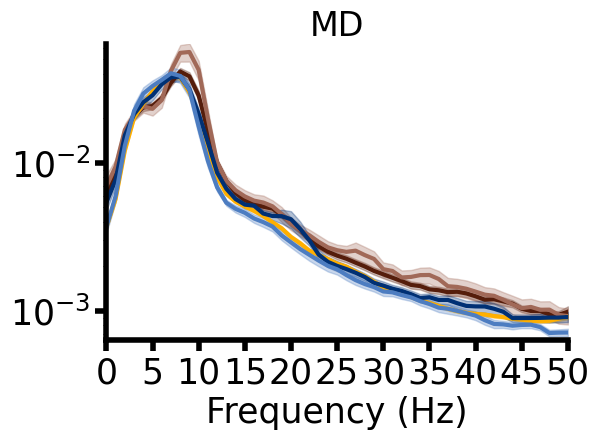

cluster_mean_trial_mPFC_power_all_frequencies_all_windows
lose_competitive
(60, 56)
[4.94759941e-04 5.62092262e-04 8.89179723e-04 1.19016587e-03
 1.23255770e-03 1.36695465e-03 1.42965591e-03 1.32247509e-03
 1.14615210e-03 1.02950074e-03 8.30781002e-04 7.10796838e-04
 5.07054600e-04 3.21344521e-04 2.01910499e-04 1.54600738e-04
 1.34073139e-04 1.36888175e-04 1.46051224e-04 1.43045889e-04
 1.31649793e-04 1.23643463e-04 1.09332364e-04 1.02849156e-04
 9.32019273e-05 9.55407566e-05 9.45287310e-05 8.74011851e-05
 8.47331647e-05 8.93262318e-05 8.83665001e-05 9.16631223e-05
 8.69510920e-05 8.24414217e-05 8.07916865e-05 7.96830385e-05
 7.62242516e-05 7.38533200e-05 6.73864482e-05 6.40714753e-05
 6.56368217e-05 5.97008322e-05 5.80630565e-05 6.03489306e-05
 5.67495836e-05 5.36552538e-05 5.13212901e-05 5.04418028e-05
 4.99335469e-05 5.22186095e-05 6.06868461e-05]
lose_no_comp
(15, 56)
[1.27002045e-03 1.87387621e-03 2.58157933e-03 2.48192666e-03
 2.26997640e-03 1.95092154e-03 1.85315882e-03 1.875051

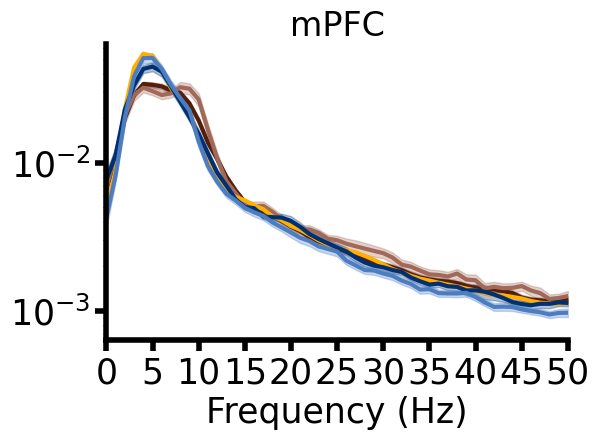

cluster_mean_trial_vHPC_power_all_frequencies_all_windows
lose_competitive
(60, 56)
[3.46954950e-04 4.50754039e-04 8.43089758e-04 1.12906924e-03
 1.35777280e-03 1.35498831e-03 1.41209657e-03 1.46511558e-03
 1.43611725e-03 1.30726041e-03 9.69588099e-04 7.23353214e-04
 5.35416957e-04 4.14839202e-04 3.72828660e-04 3.63586692e-04
 3.30991645e-04 3.06158013e-04 2.91631254e-04 3.06524694e-04
 3.46233701e-04 3.07893459e-04 2.37948050e-04 2.15480442e-04
 1.93862658e-04 1.96087243e-04 1.88642672e-04 1.65061465e-04
 1.62182961e-04 1.58941924e-04 1.58833143e-04 1.49747945e-04
 1.42350641e-04 1.46484635e-04 1.45185590e-04 1.51445593e-04
 1.47310051e-04 1.37380259e-04 1.15982848e-04 1.03991807e-04
 9.31523010e-05 9.13237039e-05 8.60965418e-05 8.01405259e-05
 7.68407550e-05 7.60944899e-05 7.38628410e-05 7.22100099e-05
 7.44498271e-05 7.77253485e-05 7.37312608e-05]
lose_no_comp
(15, 56)
[0.00144176 0.00150974 0.00174945 0.00188779 0.00263115 0.00350553
 0.00365984 0.00375668 0.00315114 0.00303412 0.0

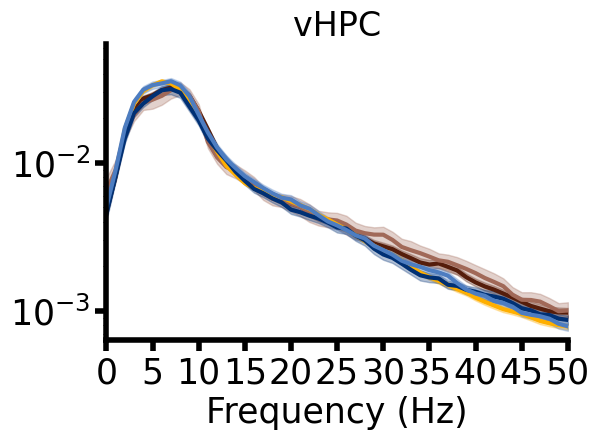

In [156]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each brain region
for col in cluster_mean_columns:
    if "velocity" in col:
        continue
    if "all_frequencies" not in col:
        continue
    print(col)

    fig, ax = plt.subplots()
    plt.xlim(low_freq, high_freq-1) 
    plt.xticks(np.arange(low_freq, high_freq, 5))

    stacked_df = combined_sampled_df.groupby("trial_and_competitiveness_label").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    stacked_df = stacked_df[~stacked_df["trial_and_competitiveness_label"].str.contains("tie")]

    stacked_df["color"] = stacked_df["trial_and_competitiveness_label"].map(comp_id_to_color)
    
    if "power" in col:
        # plt.ylim(0,0.01)
        # plt.yscale("log")
        plt.ylim((10**-3.2,10**-1.2))
        # plt.set_ylim(auto=True)
        # plt.ylim(0, 0.5)
        ax.set_yscale('log')
        # plt.ylim(0, max_value)
    elif "coherence" in col:
        plt.ylim(0.3, 0.85)
        plt.yticks(np.arange(0.3, 0.85, 0.1)) 
    elif "granger" in col:
        plt.ylim(0.2, 0.8)
        plt.yticks(np.arange(0.2, 0.85, 0.1)) 
    else:
        # pass
        plt.ylim()
    
    # Iterating through each trial type
    for index, row in stacked_df.iterrows():
        print(row["trial_and_competitiveness_label"])
        print(row[col].shape)
        #### DURING TRIAL ####
        mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
        # mean_power = np.nanmedian(row[col], axis=0)[low_freq: high_freq]

        
        sem_power = np.nanstd(row[col], axis=0) / np.sqrt(row[col].shape[0])
        sem_power = sem_power[low_freq: high_freq]
        print(sem_power)

        plt.fill_between(current_frequencies, 
        mean_power - sem_power, mean_power + sem_power, \
        alpha=0.3, color=row["color"])

        plt.plot(current_frequencies, mean_power, \
        label="{}".format(row["trial_and_competitiveness_label"]), linewidth=3, color=row["color"])
    
    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    plt.title(title)
    plt.xlabel("Frequency (Hz)", fontsize=25)
    
    if "power" in col:
        # plt.ylabel("Normalized Power (a.u.)")
        output_dir = "./proc/cluster_spectra_plots/sampled/power"

    elif "coherence" in col:
        # plt.ylabel("Coherence")
        output_dir = "./proc/cluster_spectra_plots/sampled/coherence"

    elif "granger" in col:
        # plt.ylabel("Granger's Causality")
        output_dir = "./proc/cluster_spectra_plots/sampled/granger"
    
    os.makedirs(output_dir, exist_ok=True)

    # plt.legend(fontsize=10)
    
    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_linewidth(4)

    ax.tick_params(length=8, width=4)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)

    plt.tight_layout()    
    plt.savefig("{}/{}".format(output_dir, "cluster_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())), transparent=True)
    plt.show()


In [ ]:
raise ValueError()

In [138]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF.to_pickle("./proc/cluster_exploded_TRIALS_AND_SPECTRAL_DF.pkl")

In [139]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = cluster_exploded_TRIALS_AND_SPECTRAL_DF.copy()

In [ ]:
plt.hist(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [141]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["velocity_zscore"] = stats.zscore(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [142]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["velocity_zscore"] <= 2]

In [ ]:
plt.hist(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["cluster_mean_trial_subject_thorax_velocity"])

In [ ]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF

In [ ]:
for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.columns:
    print(col)

In [146]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.reset_index().rename({"index": "index_num"})

In [147]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[[col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col) or (col in ["trial_and_competitiveness_label", "current_subject", "index_num"])]]

In [148]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.to_csv("./proc/export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.csv")

In [ ]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["current_subject"].unique()

In [ ]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[["trial_and_competitiveness_label", "cluster_mean_trial_subject_thorax_velocity"]].groupby(["trial_and_competitiveness_label"]).mean()

In [151]:
import seaborn as sns


## Plotting

In [ ]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].unique()

In [153]:
label_to_ticks = {'rewarded': "alone\nrewarded", 'win_no_comp': "win\nnon-comp", 'lose_no_comp': "lose\nnon-comp", 'win_competitive': "win\ncomp",
       'lose_competitive': "lose\ncomp"}

In [154]:
export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["bar_ticks"] = export_cluster_exploded_TRIALS_AND_SPECTRAL_DF["trial_and_competitiveness_label"].map(label_to_ticks)

In [ ]:
col

In [ ]:
for col in [col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col)]:
    print(col)
    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 20
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True

    # Plot the transition matrix using only matplotlib
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    ax = sns.violinplot(data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
        palette=comp_id_to_color,
                        inner=None, linewidth=0, saturation=1)
    
    sns.boxplot(x='bar_ticks', y=col, data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
                width=0.2,
                # boxprops={'zorder': 2}, 
                ax=ax, fill=True, linecolor="black", linewidth=2)

    plt.legend([],[], frameon=False)

        # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
    ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')



    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    if "coherence" in col or "granger" in col:
        plt.ylim(0, 1)

    elif "theta" in col:
        plt.ylim(0, 0.04)
    elif "gamma" in col:
        plt.ylim(0, 0.004)

    if "coherence" in col:
        plt.ylabel('Coherence', size=30)

    elif "granger" in col:
        plt.ylabel('Granger Causality', size=30)

    elif "power" in col: 
        plt.ylabel('Normalized Power (a.u.)', size=30)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.xticks(rotation=90)
    plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma"))
    plt.tight_layout()
    # plt.savefig("./proc/spectra_bar/{}_bar.png".format(col.replace("cluster_mean_trial_", "")))
    plt.show()
    






- Plotting with the predicted values

In [157]:
all_predicted_df = []
for file_path in glob.glob("../../output_lmer_velocity/predicted/*"):
    current_df = pd.read_csv(file_path, index_col=0)
    current_df = current_df.rename(columns={"predicted_value": "predicted_" + current_df["col_name"].iloc[0]})
    current_df = current_df.rename(columns={"original_value": "original_" + current_df["col_name"].iloc[0]})
    current_df = current_df.drop(columns=["col_name"], errors="ignore")
    all_predicted_df.append(current_df)


In [ ]:
current_df

In [159]:
joined_df = all_predicted_df[0]
for current_df in all_predicted_df[1:]:
    joined_df = pd.merge(joined_df, current_df, on="index_num", suffixes=("", "_drop"))
    joined_df = joined_df.drop(columns=[col for col in joined_df if "_drop" in col])

In [ ]:
joined_df

- Plotting the emmeans

In [161]:
all_emmeans_df = []
for file_path in glob.glob("../../output_lmer_velocity/emmeans_csv/*with_CI*"):
    current_df = pd.read_csv(file_path, index_col=0)
    # current_df = current_df.rename(columns={"predicted_value": "predicted_" + current_df["col_name"].iloc[0]})
    # current_df = current_df.rename(columns={"original_value": "original_" + current_df["col_name"].iloc[0]})
    current_df = current_df.drop(columns=["col_name"], errors="ignore")
    current_df = current_df.dropna(subset=["emmean"])
    all_emmeans_df.append(current_df)
combined_emmeans_df = pd.concat(all_emmeans_df)


In [162]:
combined_emmeans_df["color"] = combined_emmeans_df["trial_and_competitiveness_label"].map(comp_id_to_color)

In [ ]:
current_df = combined_emmeans_df[combined_emmeans_df["spectra_metric"] == "cluster_mean_trial_vHPC_power_theta"]
for index, row in current_df.sort_values(by=["trial_and_competitiveness_label"]).iterrows():
    plt.errorbar(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"],elinewidth=4, capsize=10, markeredgewidth=4)
    plt.scatter(row["trial_and_competitiveness_label"], row["emmean"], s = 100, marker = "o", color = row["color"])
    # plt.barh(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"])

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    plt.ylabel('Estimated Marginal Means', size=20)

    # means.index, means, yerr=sems, fmt='o', color='black')


In [ ]:
0.021322 - 0.026051

		# 0.001951	6.243603	0.021322	


In [ ]:
col

In [166]:
from matplotlib.ticker import FormatStrFormatter

In [ ]:
for col in [col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col)]:
    if "timestamps" in col or "velocity" in col:
        continue  
    
    print(col)
    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.major.size'] = 20
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True

    # Plot the transition matrix using only matplotlib
    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    ax = sns.violinplot(data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
        palette=comp_id_to_color,
                        inner=None, linewidth=0, saturation=1)
    
    sns.boxplot(x='bar_ticks', y=col, data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
                width=0.2,
                # boxprops={'zorder': 2}, 
                ax=ax, fill=True, linecolor="black", linewidth=2, medianprops=dict(color="red", alpha=1))

    plt.legend([],[], frameon=False)

        # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
    ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')

    if "granger" in col:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
        title = col.replace("cluster_mean_trial_", "").replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ").replace("-to-", " to ")

    else:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
        title = col.replace("cluster_mean_trial_", "").replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")
    
    if "coherence" in col:
        plt.ylim(0, 1)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    if "granger" in col:
        plt.ylim(0, 1)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1]) 
    elif "power" in col:
        plt.ylim(0, np.round(export_cluster_exploded_TRIALS_AND_SPECTRAL_DF[col].max() * 1.25, decimals=3))
        if "theta" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        elif "gamma" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    if "coherence" in col:
        plt.ylabel('Coherence', size=30)

    elif "granger" in col:
        plt.ylabel('Granger Causality', size=30)

    elif "power" in col: 
        plt.ylabel('Normalized Power (a.u.)', size=30)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    plt.xticks(visible=False)

    ax.set(xlabel=None)
    ax.set(ylabel=None)

    plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma"), pad=50)
    plt.tight_layout()
    
    if "coherence" in col:
        sub_dir = "coherence"

    elif "granger" in col:
        sub_dir = "granger"

    elif "power" in col: 
        sub_dir = "power"

    plt.savefig("./proc/spectra_bar/{}/{}_bar.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    plt.show()
    






In [168]:
# for col in [col for col in export_cluster_exploded_TRIALS_AND_SPECTRAL_DF if ("cluster_mean_trial" in col and "all_frequencies" not in col)]:
#     if "timestamps" in col:
#         continue
    
#     print(col)
#     sns.set_style('white', {'axes.linewidth': 0.5})
#     plt.rcParams['xtick.major.size'] = 20
#     plt.rcParams['xtick.major.width'] = 4
#     plt.rcParams['xtick.bottom'] = True
#     plt.rcParams['ytick.left'] = True

#     # Plot the transition matrix using only matplotlib
#     # fig, ax = plt.subplots(figsize=(6.4, 4.8))
#     fig, ax = plt.subplots(figsize=(6.4, 4.8))


#     ax = sns.violinplot(data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
#         palette=comp_id_to_color,
#                         inner=None, linewidth=0, saturation=1)
    
#     # ax.tick_params(bottom=False)
    
#     # means = joined_df.groupby('bar_ticks')[col].mean()
#     # sems = joined_df.groupby('bar_ticks')[col].sem()

#     # Plot the means with SEM bars
#     # plt.errorbar(means.index, means, yerr=sems, fmt='o', color='black')

#     sns.boxplot(x='bar_ticks', y=col, data=export_cluster_exploded_TRIALS_AND_SPECTRAL_DF.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
#                 width=0.2,
#                 # boxprops={'zorder': 2}, 
#                 ax=ax, fill=True, linecolor="black", linewidth=2, medianprops=dict(color="red", alpha=1))

#     plt.legend([],[], frameon=False)

#         # Hide top and right borders
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Leave bottom and left spines
#     ax.spines['bottom'].set_visible(True)
#     ax.spines['left'].set_visible(True)
#     ax.spines['bottom'].set_linewidth(3)
#     ax.spines['left'].set_linewidth(3)

#     ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
#     ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')

#     if "granger" in col:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     else:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     if "coherence" in col:
#         plt.ylim(0.2, 1)
#         plt.yticks([0.2, 0.4, 0.6, 0.8, 1]) 
#     if "granger" in col:
#         plt.ylim(0.2, 0.8)
#         plt.yticks([0.2, 0.4, 0.6, 0.8]) 
#     elif "power" in col:
#         plt.ylim(0, np.round(joined_df[col].max() * 1.25, decimals=3))
#         if "theta" in col:
#             ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         elif "gamma" in col:
#             ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

#     elif "theta" in col:
#         # plt.ylim(0, 0.05)
#         pass
#     elif "gamma" in col:
#         # plt.ylim(0, 0.0075)
#         pass

#     # if "coherence" in col:
#     #     plt.ylabel('Coherence', size=25)

#     # elif "granger" in col:
#     #     plt.ylabel('Granger Causality', size=25)

#     # elif "power" in col: 
#     #     plt.ylabel('Normalized Power (a.u.)', size=25)
    
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    
#     plt.xticks(visible=False)

#     ax.set(xlabel=None)
#     ax.set(ylabel=None)


#     plt.xticks(rotation=90)
#     plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma").replace("predicted", "").strip(),  pad=50)
#     plt.tight_layout()

#     if "coherence" in col:
#         sub_dir = "coherence"

#     elif "granger" in col:
#         sub_dir = "granger"

#     elif "power" in col: 
#         sub_dir = "power"

#     plt.savefig("./proc/spectra_bar/{}/{}_bar.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
#     plt.show()



In [169]:

# joined_df["bar_ticks"] = joined_df["trial_and_competitiveness_label"].map(label_to_ticks)

# for col in [col for col in joined_df if ("cluster_mean_trial" in col and "all_frequencies" not in col and "predicted" in col)]:
#     if "timestamps" in col:
#         continue
    
#     print(col)
#     sns.set_style('white', {'axes.linewidth': 0.5})
#     plt.rcParams['xtick.major.size'] = 20
#     plt.rcParams['xtick.major.width'] = 4
#     plt.rcParams['xtick.bottom'] = True
#     plt.rcParams['ytick.left'] = True

#     # Plot the transition matrix using only matplotlib
#     # fig, ax = plt.subplots(figsize=(6.4, 4.8))
#     fig, ax = plt.subplots(figsize=(6.4, 4.8))


#     ax = sns.violinplot(data=joined_df.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
#         palette=comp_id_to_color,
#                         inner=None, linewidth=0, saturation=1)
    
#     # ax.tick_params(bottom=False)
    
#     # means = joined_df.groupby('bar_ticks')[col].mean()
#     # sems = joined_df.groupby('bar_ticks')[col].sem()

#     # Plot the means with SEM bars
#     # plt.errorbar(means.index, means, yerr=sems, fmt='o', color='black')

#     sns.boxplot(x='bar_ticks', y=col, data=joined_df.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
#                 width=0.2,
#                 # boxprops={'zorder': 2}, 
#                 ax=ax, fill=True, linecolor="black", linewidth=2, medianprops=dict(color="red", alpha=1))

#     plt.legend([],[], frameon=False)

#         # Hide top and right borders
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Leave bottom and left spines
#     ax.spines['bottom'].set_visible(True)
#     ax.spines['left'].set_visible(True)
#     ax.spines['bottom'].set_linewidth(3)
#     ax.spines['left'].set_linewidth(3)

#     ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
#     ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')

#     if "granger" in col:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     else:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     if "coherence" in col:
#         # plt.ylim(0.2, 1)
#         # plt.yticks([0.2, 0.4, 0.6, 0.8, 1]) 
#         pass
#     if "granger" in col:
#         # plt.ylim(0.2, 0.8)
#         # plt.yticks([0.2, 0.4, 0.6, 0.8])
#         pass 
#     elif "power" in col:
#         # plt.ylim(0, np.round(joined_df[col].max() * 1.25, decimals=3))
#         # if "theta" in col:
#         #     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         # elif "gamma" in col:
#         #     ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#         pass


#     elif "theta" in col:
#         # plt.ylim(0, 0.05)
#         pass
#     elif "gamma" in col:
#         # plt.ylim(0, 0.0075)
#         pass

#     # if "coherence" in col:
#     #     plt.ylabel('Coherence', size=25)

#     # elif "granger" in col:
#     #     plt.ylabel('Granger Causality', size=25)

#     # elif "power" in col: 
#     #     plt.ylabel('Normalized Power (a.u.)', size=25)
    
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    
#     plt.xticks(visible=False)

#     ax.set(xlabel=None)
#     ax.set(ylabel=None)


#     plt.xticks(rotation=90)
#     plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma").replace("predicted", "").strip(),  pad=50)
#     plt.tight_layout()

#     if "coherence" in col:
#         sub_dir = "coherence"

#     elif "granger" in col:
#         sub_dir = "granger"

#     elif "power" in col: 
#         sub_dir = "power"

#     plt.savefig("./proc/spectra_bar/{}/{}_bar.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
#     plt.show()
#     # break
    






In [170]:

# joined_df["bar_ticks"] = joined_df["trial_and_competitiveness_label"].map(label_to_ticks)

# for col in [col for col in joined_df if ("cluster_mean_trial" in col and "all_frequencies" not in col and "predicted" in col)]:
#     if "timestamps" in col:
#         continue
    
#     print(col)
#     sns.set_style('white', {'axes.linewidth': 0.5})
#     plt.rcParams['xtick.major.size'] = 20
#     plt.rcParams['xtick.major.width'] = 4
#     plt.rcParams['xtick.bottom'] = True
#     plt.rcParams['ytick.left'] = True

#     # Plot the transition matrix using only matplotlib
#     fig, ax = plt.subplots(figsize=(6.4, 4.8))

#     ax = sns.violinplot(data=joined_df.sort_values(["trial_and_competitiveness_label"]), x='bar_ticks', y=col, hue='trial_and_competitiveness_label',
#         palette=comp_id_to_color,
#                         inner=None, linewidth=0, saturation=1)
    
#     # ax.tick_params(bottom=False)
    
#     # means = joined_df.groupby('bar_ticks')[col].mean()
#     # sems = joined_df.groupby('bar_ticks')[col].sem()

#     # Plot the means with SEM bars
#     # plt.errorbar(means.index, means, yerr=sems, fmt='o', color='black')

#     sns.boxplot(x='bar_ticks', y=col, data=joined_df.sort_values(["trial_and_competitiveness_label"]), color='white',            # hue='competitiveness_grouping',    palette=comp_to_color, 
#                 width=0.2,
#                 # boxprops={'zorder': 2}, 
#                 ax=ax, fill=True, linecolor="black", linewidth=2)

#     plt.legend([],[], frameon=False)

#         # Hide top and right borders
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Leave bottom and left spines
#     ax.spines['bottom'].set_visible(True)
#     ax.spines['left'].set_visible(True)
#     ax.spines['bottom'].set_linewidth(3)
#     ax.spines['left'].set_linewidth(3)

#     ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
#     ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')

#     if "granger" in col:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     else:
#         # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
#         title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

#     if "coherence" in col or "granger" in col:
#         plt.ylim(0, 1)

#     elif "theta" in col:
#         plt.ylim(0, 0.04)
#     elif "gamma" in col:
#         plt.ylim(0, 0.004)

#     if "coherence" in col:
#         plt.ylabel('Coherence', size=25)

#     elif "granger" in col:
#         plt.ylabel('Granger Causality', size=25)

#     elif "power" in col: 
#         plt.ylabel('Normalized Power (a.u.)', size=25)
    
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    
#     plt.xticks(visible=False)

#     ax.set(xlabel=None)

#     plt.xticks(rotation=90)
#     plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma").replace("predicted", "").strip())
#     plt.tight_layout()
#     plt.savefig("./proc/spectra_bar/{}_bar.png".format(col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
#     plt.show()
#     # break

In [ ]:
for col in [col for col in joined_df if ("cluster_mean_trial" in col and "all_frequencies" not in col and "predicted" in col)]:
    if "timestamps" in col:
        continue
    
    print(col)


    # Plot the transition matrix using only matplotlib
    fig, ax = plt.subplots(figsize=(6.4, 4.8))


    current_df = combined_emmeans_df[combined_emmeans_df["spectra_metric"] == col.replace("predicted_", "")]
    for index, row in current_df.sort_values(by=["trial_and_competitiveness_label"]).iterrows():
        plt.errorbar(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"],elinewidth=4, capsize=10, markeredgewidth=4)
        plt.scatter(row["trial_and_competitiveness_label"], row["emmean"], s = 100, marker = "o", color = row["color"])
        # plt.barh(row["trial_and_competitiveness_label"], row["emmean"], yerr=row["upper.CL"] - row["emmean"], fmt='o', color=row["color"])

        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        
    # plt.ylabel('Estimated Marginal Means', size=20)

        # means.index, means, yerr=sems, fmt='o', color='black')

    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)

    ax.tick_params(axis='both', which='major', labelsize=23, length=10, width=3, color='black')
    ax.tick_params(axis='both', which='minor', labelsize=23, length=10, width=3, color='black')


    if "granger" in col:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").replace("predicted", "").strip()
        title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

    else:
        # title = "{}".format(col.replace(".", "-").replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").replace("predicted", "").strip()
        title = col.replace("predicted_cluster_mean_trial_", "").replace("power", "").replace("granger", "").replace("coherence", "").replace("_", " ").replace("  ", " ").replace(".", " ")

    if "coherence" in col or "granger" in col:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    elif "power" in col:
        if "theta" in col:
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        elif "gamma" in col:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))


    plt.title(title.replace("theta", "Theta").replace("gamma", "Gamma").replace("predicted", "").strip(),  pad=50)
    plt.tight_layout()
    
    # plt.savefig("./proc/emmeans/{}_emmeans.png".format(col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    if "coherence" in col:
        sub_dir = "coherence"

    elif "granger" in col:
        sub_dir = "granger"

    elif "power" in col: 
        sub_dir = "power"

    plt.savefig("./proc/emmeans/{}/{}_emmeans.png".format(sub_dir, col.replace("cluster_mean_trial_", "").replace("predicted_", "")))
    
    plt.show()


- Getting all the significant values

In [172]:
all_significance_df = []
for file_path in glob.glob("../../output_lmer_velocity/emmeans_csv/*"):
    if "with_CI" in file_path:
        continue
    current_df = pd.read_csv(file_path, index_col=0)
    all_significance_df.append(current_df)
combined_significance_df = pd.concat(all_significance_df)


In [ ]:
combined_significance_df["contrast"].unique()

In [174]:
valid_comparisons = [
                    # 'rewarded - lose_no_comp', 
                    'rewarded - win_competitive',
                    'rewarded - lose_competitive', 
                    # 'win_no_comp - lose_competitive',
                    'win_no_comp - lose_no_comp', 
                    'win_no_comp - win_competitive',
                    # 'lose_no_comp - win_competitive',
                    'lose_no_comp - lose_competitive',
                    'win_competitive - lose_competitive', 
                    'rewarded - win_no_comp'
                    ]

In [175]:
combined_significance_df = combined_significance_df[combined_significance_df["p.value"] <= 0.05]

In [176]:
combined_significance_df = combined_significance_df[combined_significance_df["contrast"].isin(valid_comparisons)]

In [177]:
def get_signficance_stars(p_value):
    """
    """
    if p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return ""

In [178]:
combined_significance_df["signficance_stars"] = combined_significance_df["p.value"].apply(lambda x: get_signficance_stars(x))

In [179]:
combined_significance_df["metric"] = combined_significance_df["spectra_metric"].apply(lambda x: x.split("_")[-2])
combined_significance_df["band"] = combined_significance_df["spectra_metric"].apply(lambda x: x.split("_")[-1])

In [180]:
combined_significance_df["contrast"] = combined_significance_df["contrast"].apply(lambda x: sorted([word.strip() for word in x.split("-")]))

In [181]:
combined_significance_df["label_1"] = combined_significance_df["contrast"].apply(lambda x: x[0])
combined_significance_df["label_2"] = combined_significance_df["contrast"].apply(lambda x: x[1])

In [182]:
combined_significance_df["is_comp_comparison"] = combined_significance_df["contrast"].apply(lambda x: x[0].split("_")[0] == x[1].split("_")[0])

In [183]:
combined_significance_df = combined_significance_df.sort_values(["metric", "band", "spectra_metric", "label_1", "label_2"])

In [ ]:
combined_significance_df[~combined_significance_df["is_comp_comparison"]].tail(n=30)

In [ ]:
combined_significance_df[~combined_significance_df["is_comp_comparison"]].shape

In [ ]:
combined_significance_df[combined_significance_df["is_comp_comparison"]]

In [ ]:
combined_significance_df[combined_significance_df["is_comp_comparison"]].shape

In [ ]:
# combined_significance_df[combined_significance_df["metric"] == "coherence"]

combined_significance_df[(combined_significance_df["metric"] == "coherence") & (combined_significance_df["spectra_metric"].str.contains("mPFC"))]

In [ ]:
combined_significance_df[(combined_significance_df["metric"] == "coherence") & (combined_significance_df["contrast"].apply(lambda x: "lose_no_comp" in x))]

In [ ]:
combined_significance_df[(combined_significance_df["metric"] == "granger") & (combined_significance_df["contrast"].apply(lambda x: "lose_no_comp" in x))]

In [ ]:
combined_significance_df["contrast"]

# Checking subject variability

In [ ]:
cluster_exploded_TRIALS_AND_SPECTRAL_DF["current_subject"]

low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

for subj in cluster_exploded_TRIALS_AND_SPECTRAL_DF["current_subject"].unique():
    subj_df = cluster_exploded_TRIALS_AND_SPECTRAL_DF[cluster_exploded_TRIALS_AND_SPECTRAL_DF["current_subject"] == subj].copy()

    # Iterating through each brain region
    for col in cluster_mean_columns:
        if "velocity" in col:
            continue
        if "all_frequencies" not in col:
            continue
        print(col)

        fig, ax = plt.subplots()
        plt.xlim(low_freq, high_freq-1) 
        plt.xticks(np.arange(low_freq, high_freq, 5))

        stacked_df = subj_df.groupby("trial_and_competitiveness_label").agg({col: stack_arrays})
        stacked_df = stacked_df.reset_index()
        stacked_df = stacked_df[~stacked_df["trial_and_competitiveness_label"].str.contains("tie")]

        stacked_df["color"] = stacked_df["trial_and_competitiveness_label"].map(comp_id_to_color)
        
        if "power" in col:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            plt.ylim((10**-3.2,10**-1.2))
            # plt.set_ylim(auto=True)
            # plt.ylim(0, 0.5)
            ax.set_yscale('log')
            # plt.ylim(0, max_value)
        elif "coherence" in col:
            # plt.ylim(0.3, 0.85)
            plt.ylim(0,1)
            # plt.yticks(np.arange(0.3, 0.85, 0.1)) 
        elif "granger" in col:
            # plt.ylim(0.2, 0.8)
            plt.ylim(0,1)
            # plt.yticks(np.arange(0.2, 0.85, 0.1)) 
        else:
            # pass
            plt.ylim()
        
        # Iterating through each trial type
        for index, row in stacked_df.iterrows():
            print(row["trial_and_competitiveness_label"])
            print(row[col].shape)
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            
            sem_power = np.nanstd(row[col], axis=0) / np.sqrt(row[col].shape[0])
            sem_power = sem_power[low_freq: high_freq]
            print(sem_power)

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.3, color=row["color"])

            plt.plot(current_frequencies, mean_power, \
            label="{}".format(row["trial_and_competitiveness_label"]), linewidth=3, color=row["color"])
        
        if "granger" in col:
            title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
        else:
            title = "{}".format(col.replace("cluster_mean_trial_", "").replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

        plt.title("{} {}".format(subj, title))
        plt.xlabel("Frequency (Hz)", fontsize=25)
        
        if "power" in col:
            # plt.ylabel("Normalized Power (a.u.)")
            output_dir = "./proc/subj/cluster_spectra_plots/power"

        elif "coherence" in col:
            # plt.ylabel("Coherence")
            output_dir = "./proc/subj/cluster_spectra_plots/coherence"

        elif "granger" in col:
            # plt.ylabel("Granger's Causality")
            output_dir = "./proc/subj/cluster_spectra_plots/granger"
        
        os.makedirs(output_dir, exist_ok=True)

        # plt.legend(fontsize=10)
        
        # Hide top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Leave bottom and left spines
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_linewidth(4)
        ax.spines['left'].set_linewidth(4)

        ax.tick_params(length=8, width=4)
        plt.yticks(fontsize=25)
        plt.xticks(fontsize=25)

        plt.tight_layout()    
        plt.savefig(os.path.join(output_dir, "cluster_{}_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip(), subj)), transparent=True)
        plt.show()
